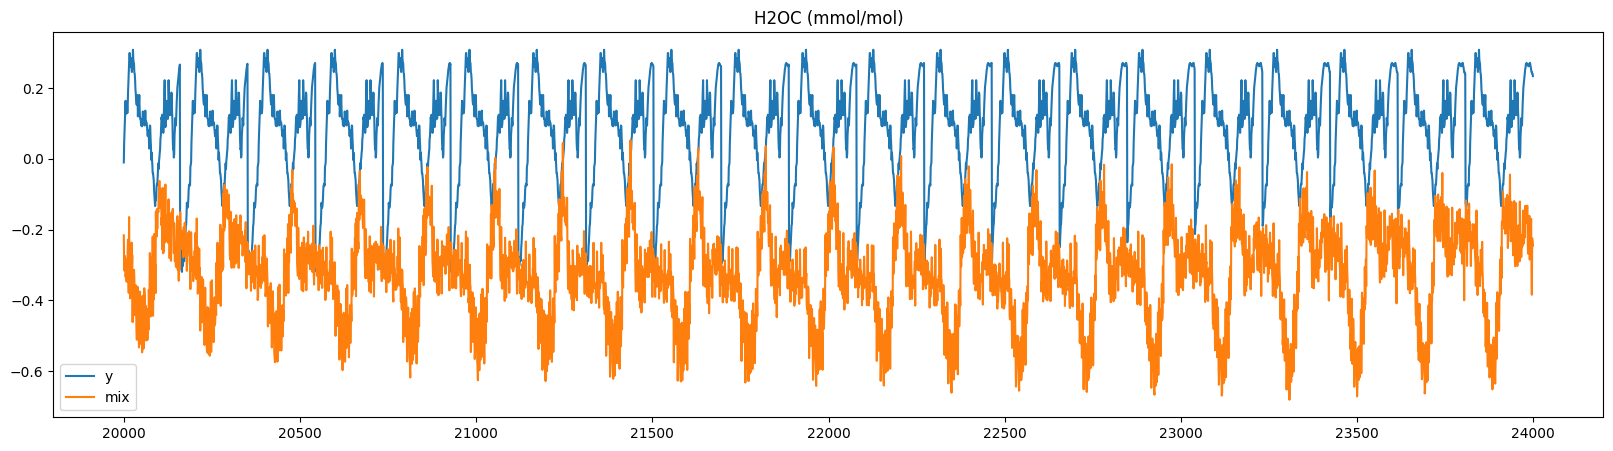

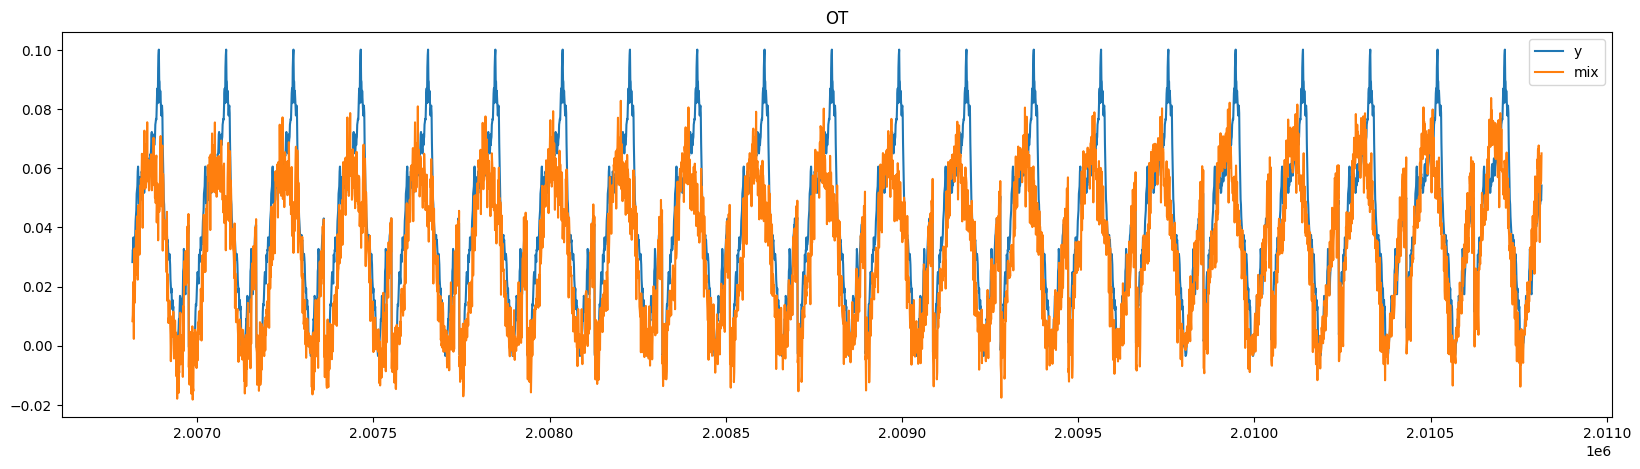

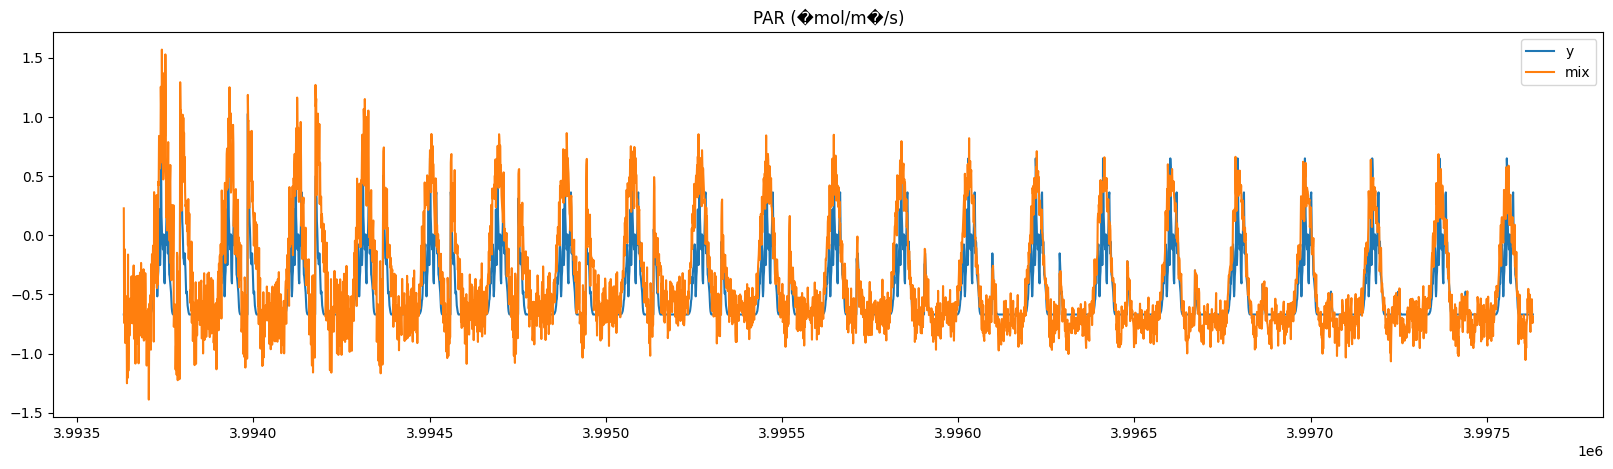

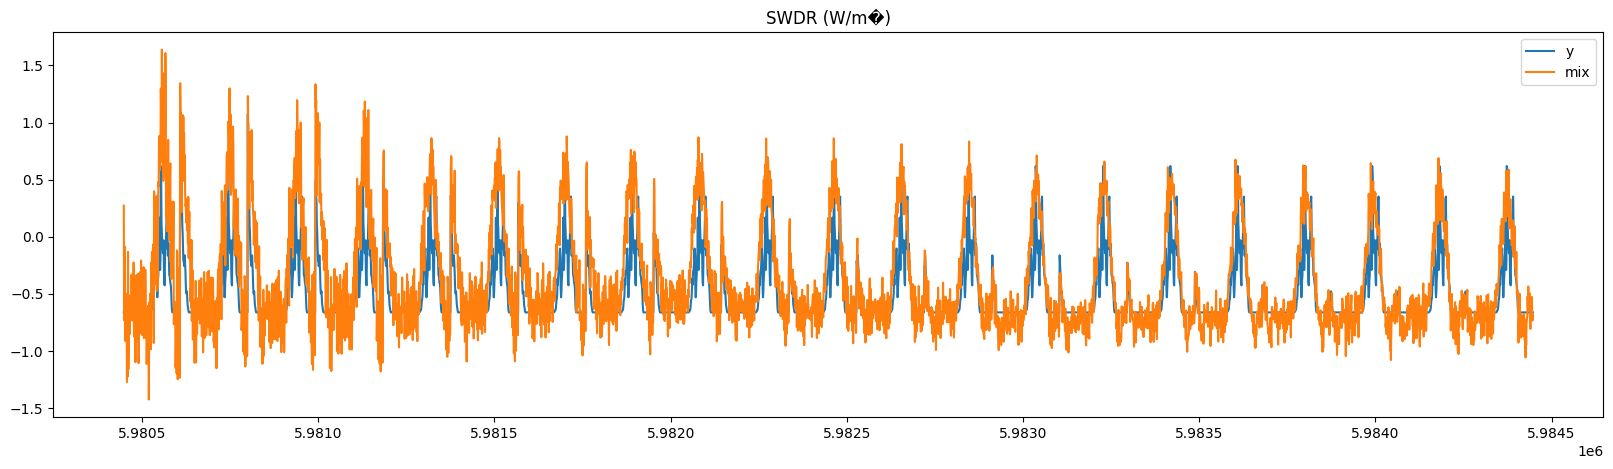

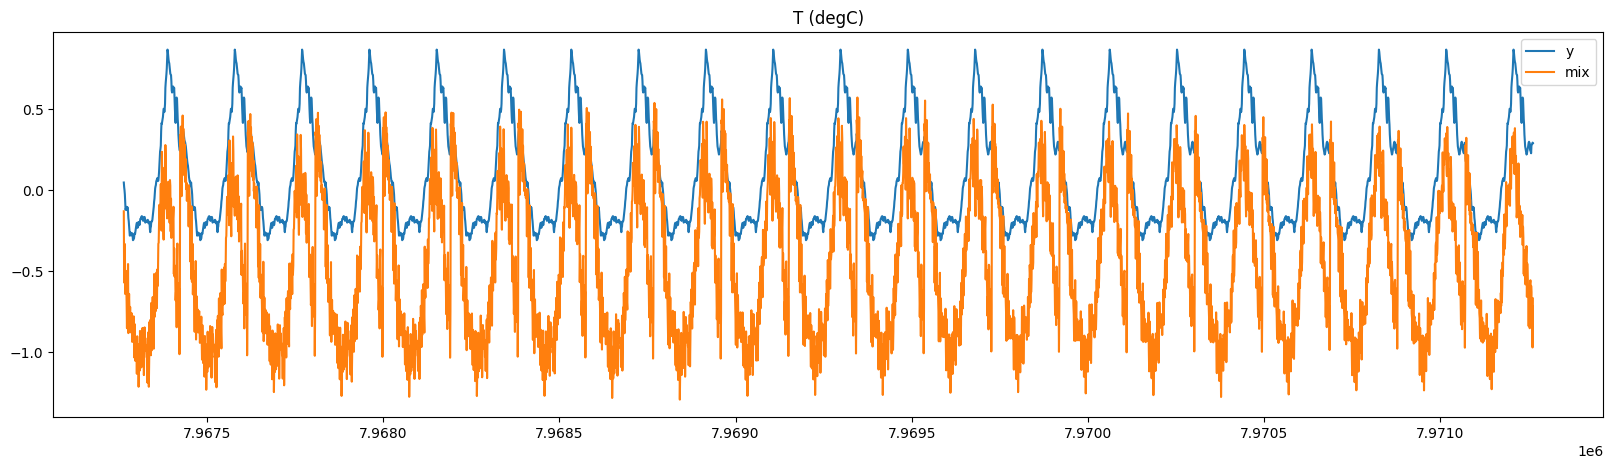

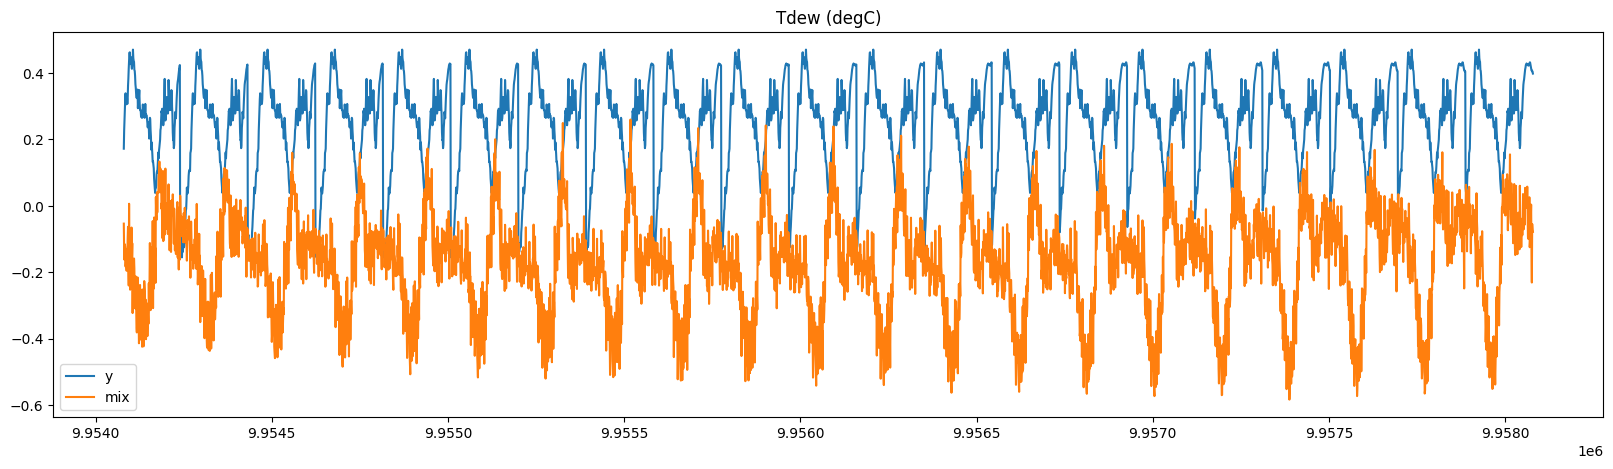

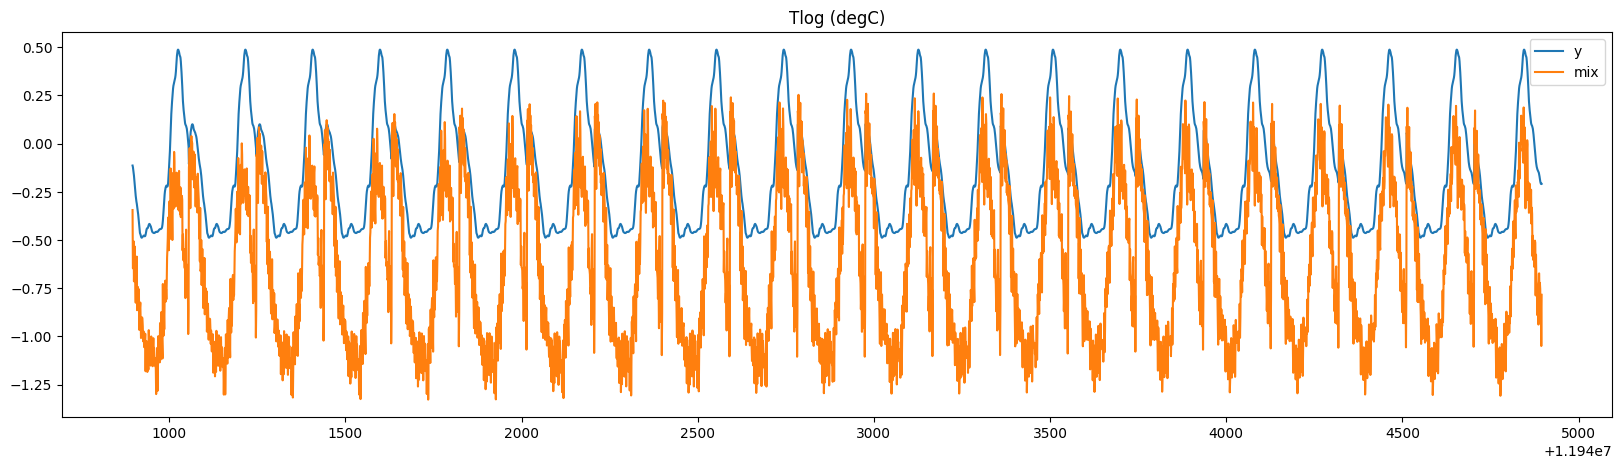

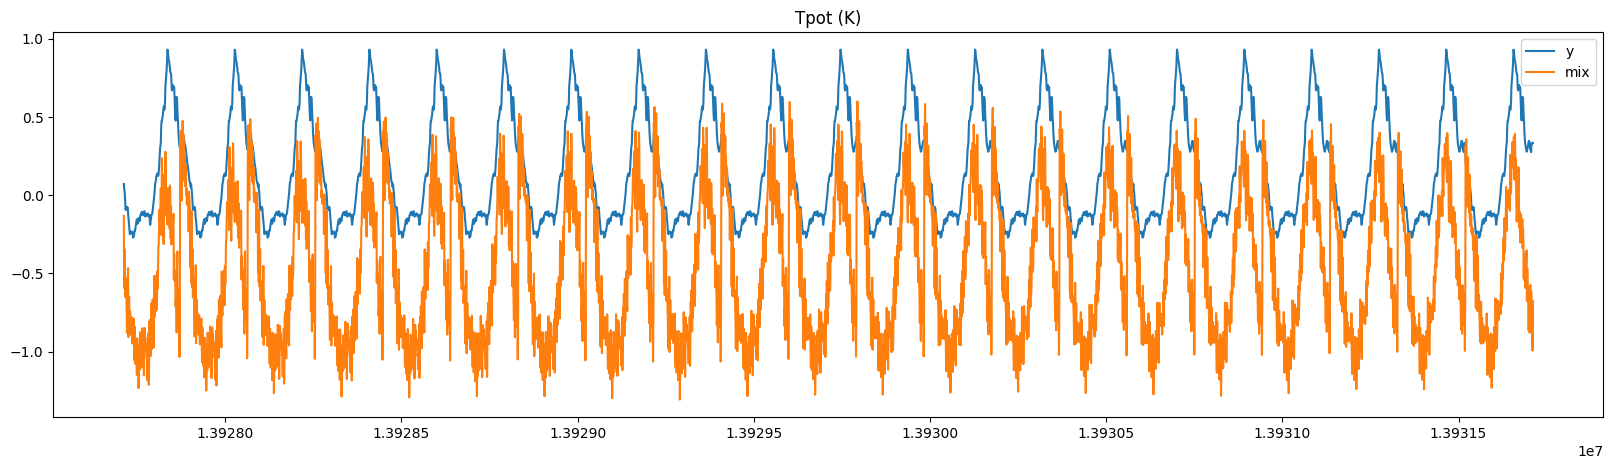

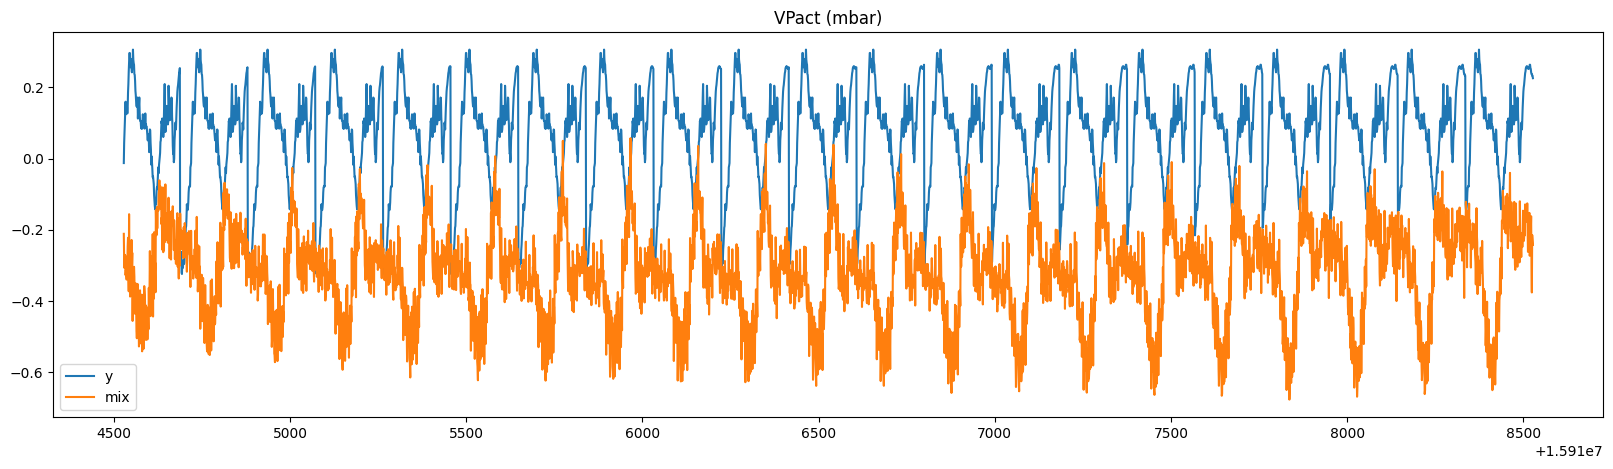

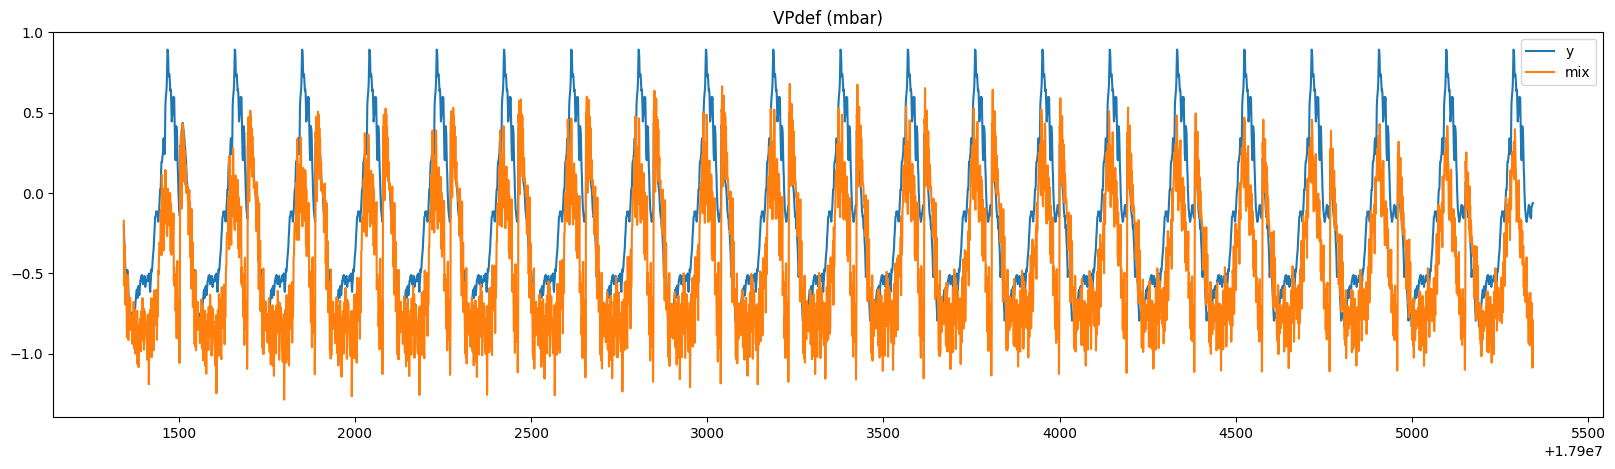

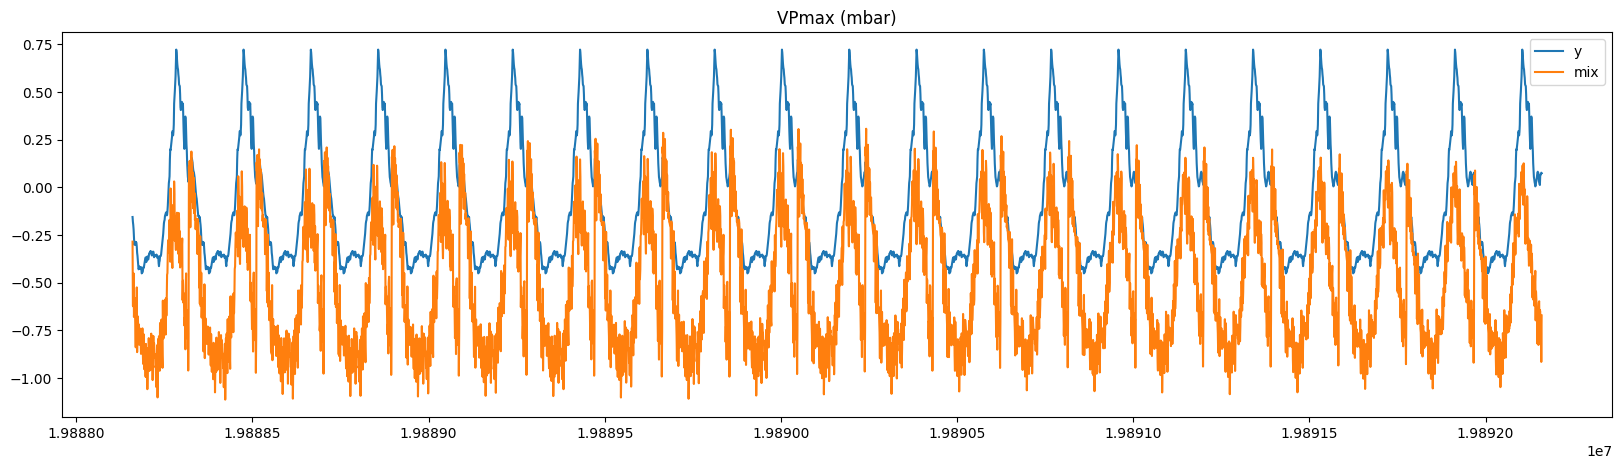

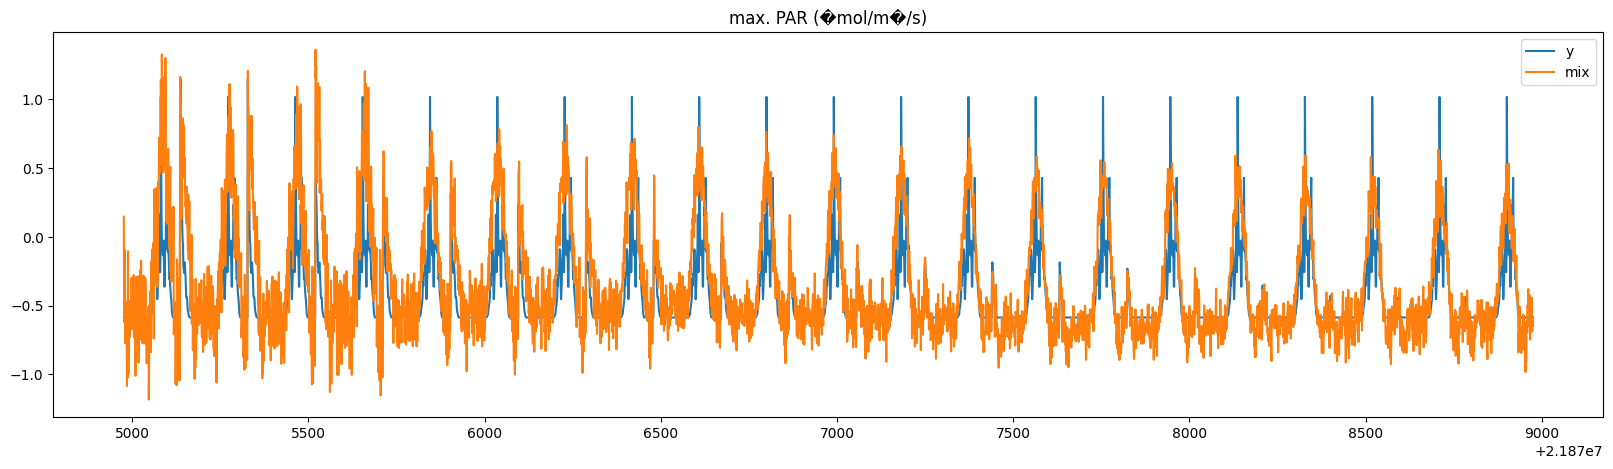

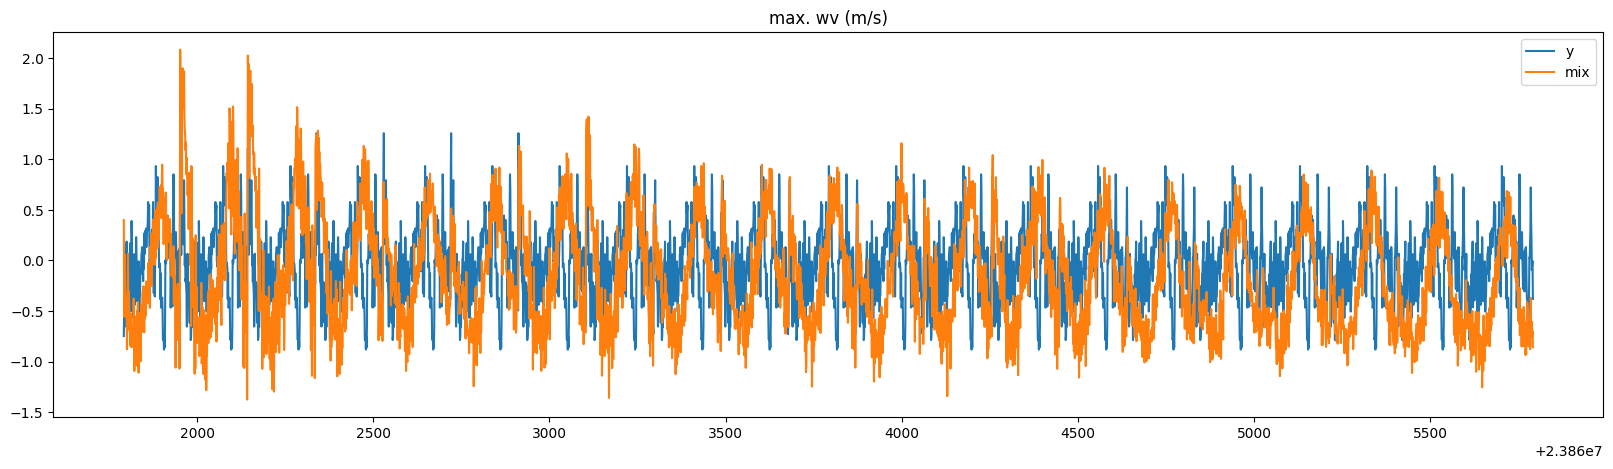

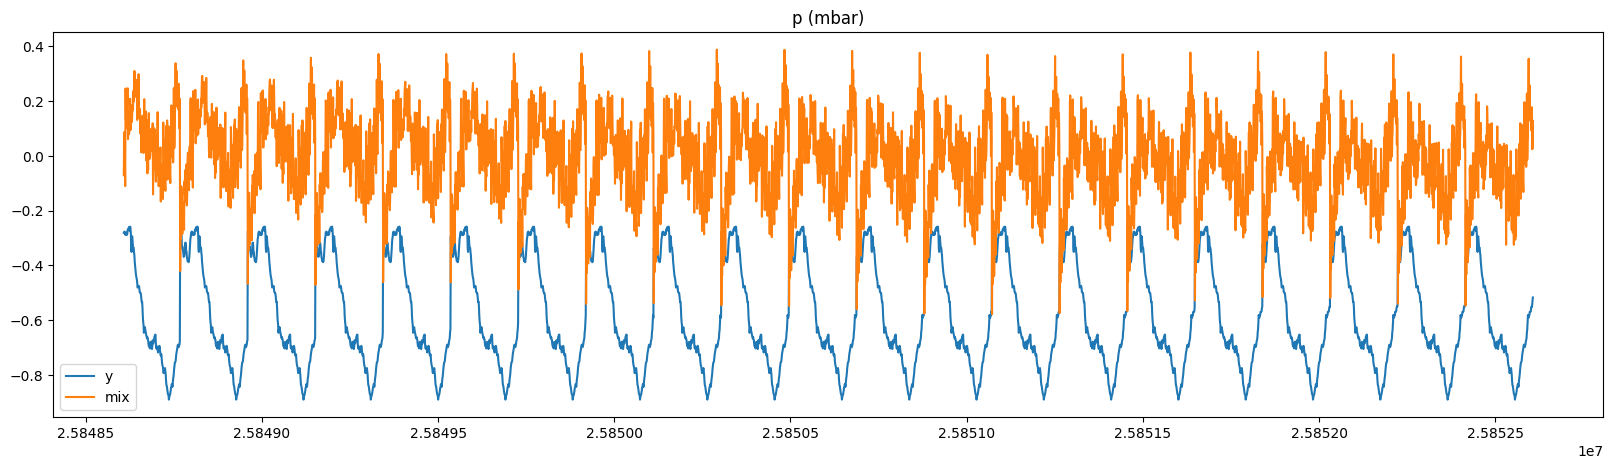

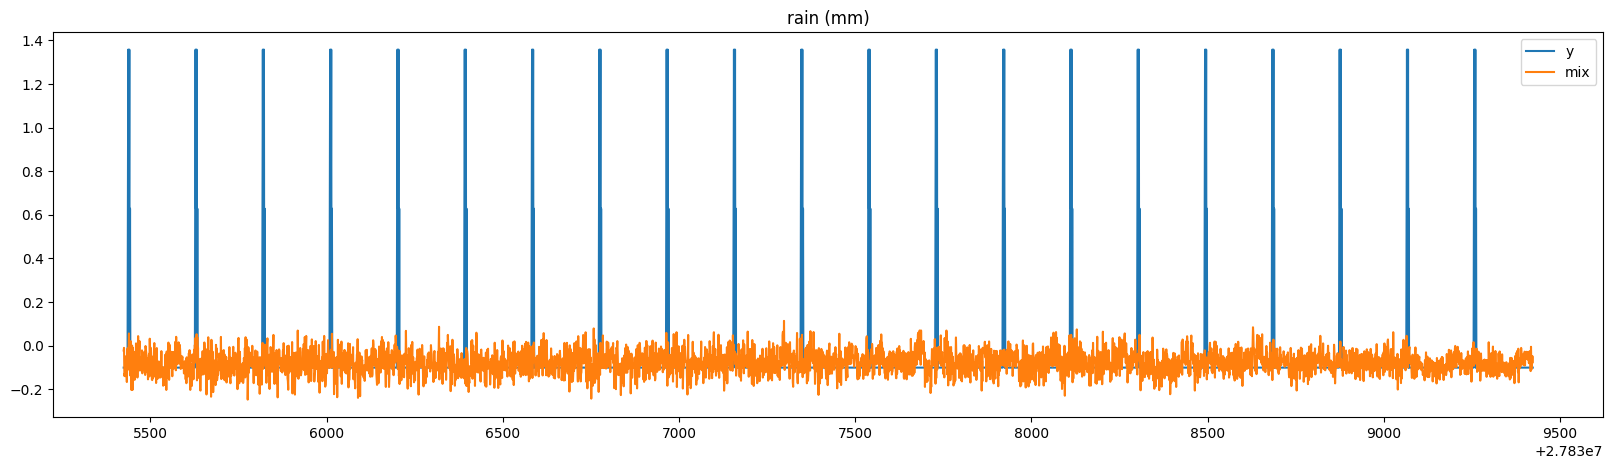

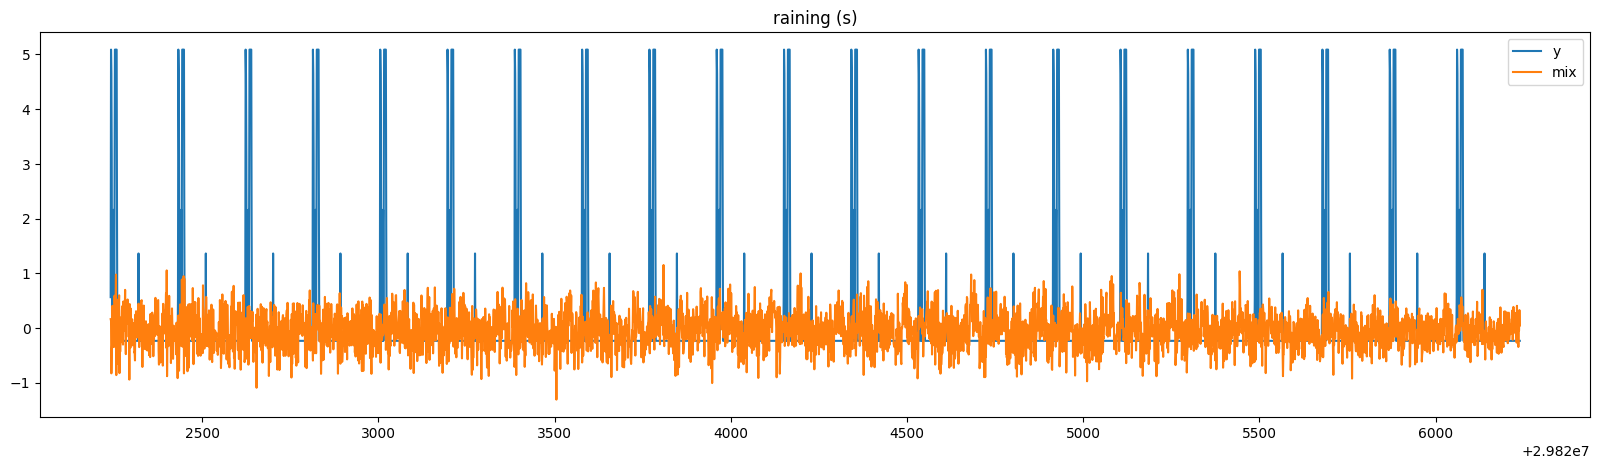

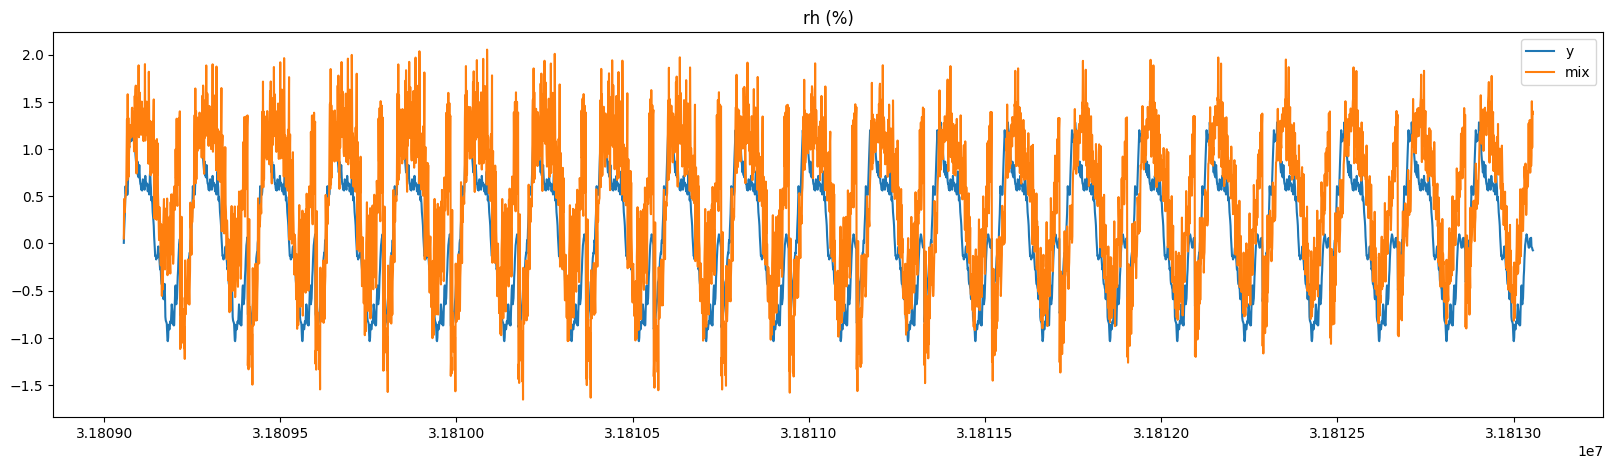

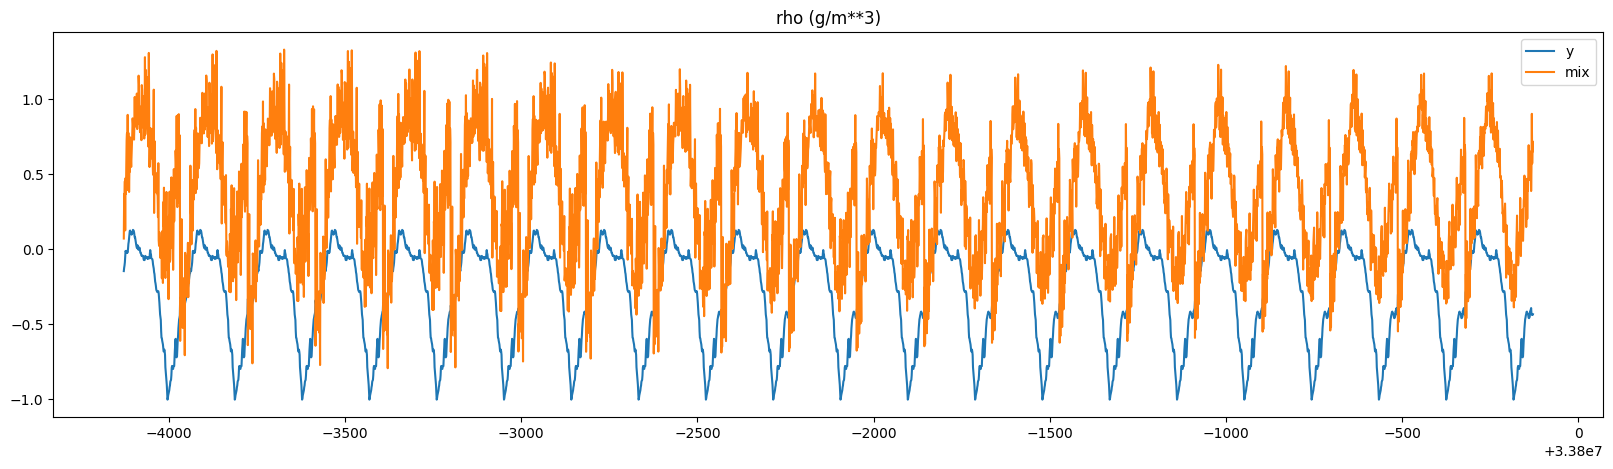

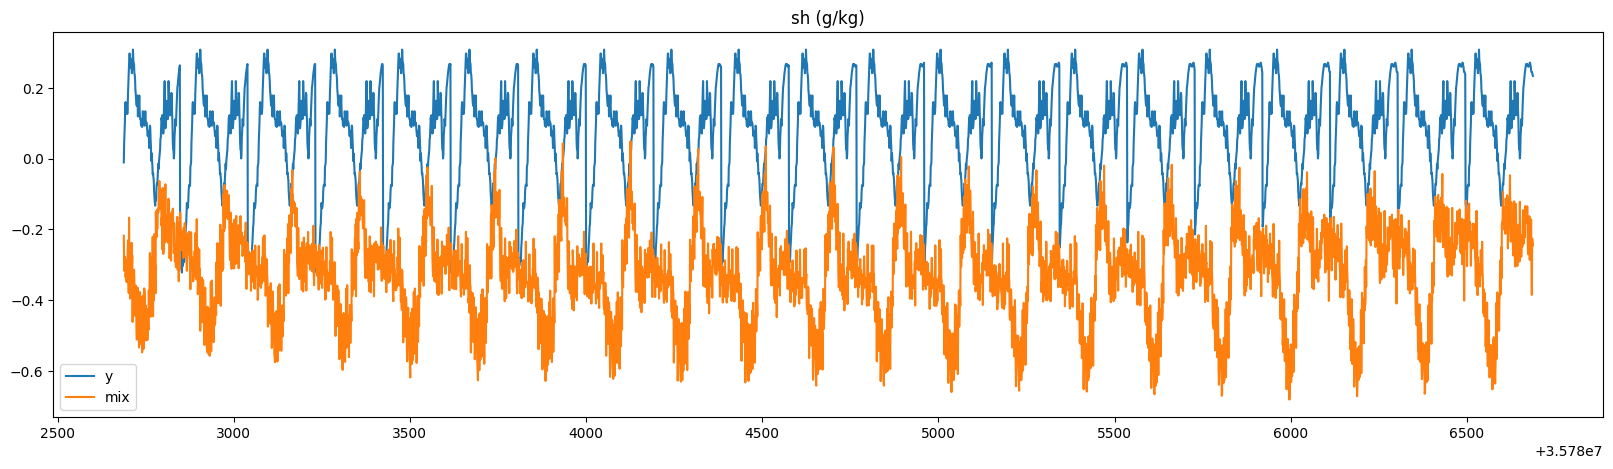

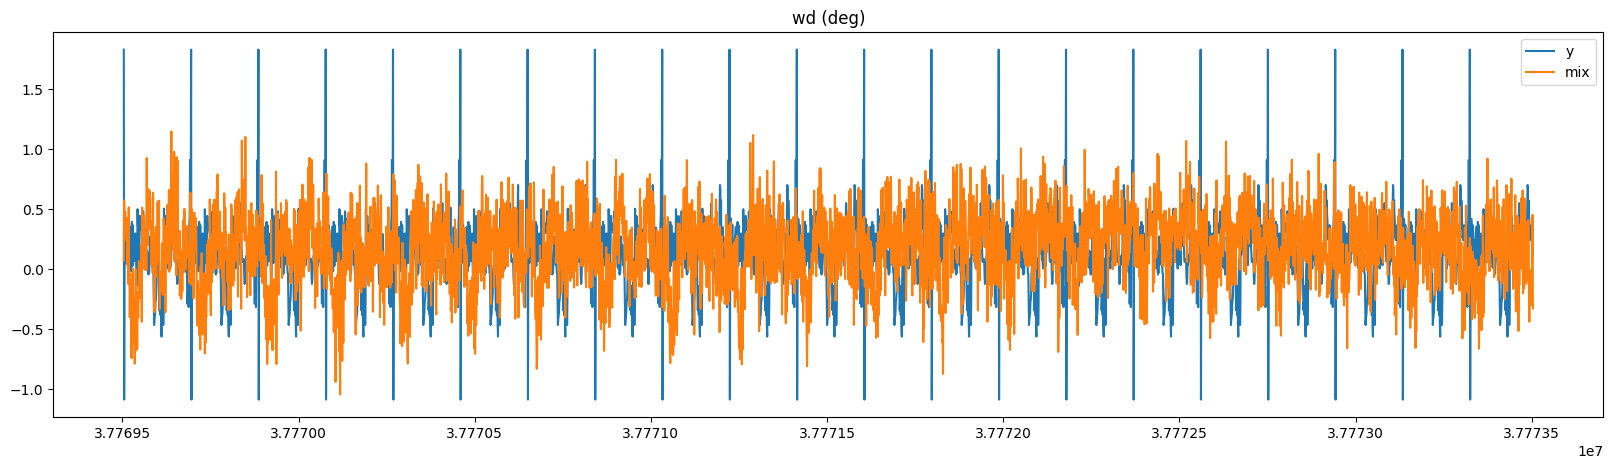

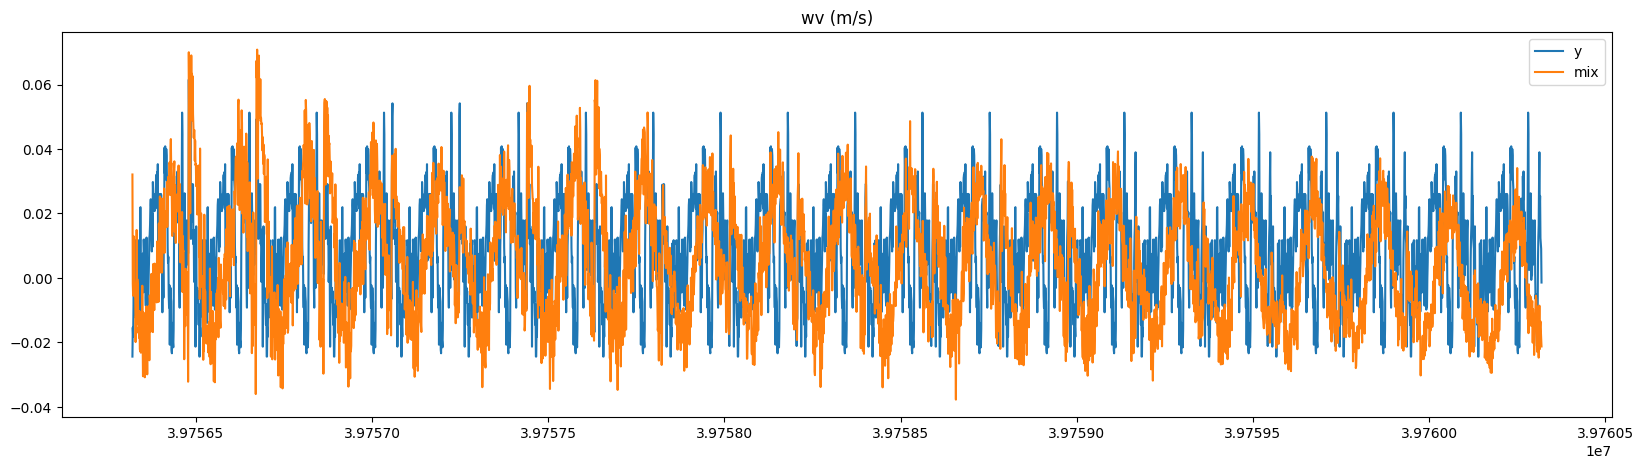

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
# 为什么在weather上的结果不好，实际观察来看，在绝大多数时候是好过NHITS的，但是求出来的值并不好
mix = pd.read_csv('data/192_mix_std_deco_forecasts.csv')
# nhits = pd.read_csv('data/96_nhits_forecasts.csv')
for column in mix['unique_id'].unique():

    
    plt.figure(figsize=(20,5))
    plt.title(column)
    plt.plot(mix[mix['unique_id']==column][20000:24000]['y'],label='y')
    plt.plot(mix[mix['unique_id']==column][20000:24000]['AutoMIXModel'],label='mix')
    plt.legend()


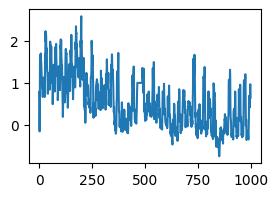

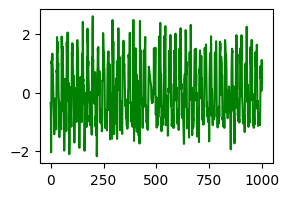

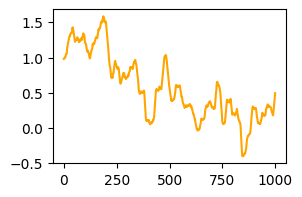

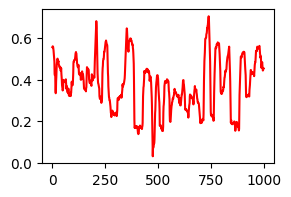

In [40]:
### 测试两个序列模块


import torch
import torch.nn as nn

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """

    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class moving_std(nn.Module):
    """
    Moving standard deviation block for time series data
    """

    def __init__(self, kernel_size, stride):
        super(moving_std, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        # Calculate the standard deviation using a sliding window
        batch_size, seq_len, num_features = x.size()
        pad_size = min((self.kernel_size - 1) // 2, seq_len - 1)
        padded_x = torch.nn.functional.pad(x.permute(0,2,1), (pad_size, pad_size), mode='reflect').permute(0,2,1)
        std_values = []
       
        for i in range(0, seq_len, self.stride):
            window = padded_x[:, i:i+self.kernel_size, :]
            std = torch.std(window, dim=1, unbiased=False)
            std_values.append(std)
        std_values = torch.stack(std_values, dim=1)
        return std_values
    
from datasetsforecast.long_horizon2 import LongHorizon2, LongHorizon2Info    
Y_df = LongHorizon2.load(directory="./data/", group='ETTh1')
Y_df["ds"] = pd.to_datetime(Y_df["ds"])
import torch
input_sequence = torch.tensor(Y_df["y"].values[1000:2000])

input_sequence = input_sequence.unsqueeze(0).unsqueeze(2)

mv = moving_avg(25,1)
ms = moving_std(25,1)
seq_std = ms(input_sequence)
seq_mean = mv(input_sequence)
seq_norm = (input_sequence - seq_mean)/seq_std

import matplotlib.pyplot as plt
plt.figure(figsize=(3,2))
plt.plot(input_sequence[0].T[0])
plt.show()
plt.figure(figsize=(3,2))
plt.plot(seq_norm[0].T[0],color='green')
plt.show()
plt.figure(figsize=(3,2))
plt.plot(seq_mean[0].T[0],color='orange')
plt.show()
plt.figure(figsize=(3,2))
plt.plot(seq_std[0].T[0],color='red')
plt.show()

# plt.plot((input_sequence[0].T[0] - seq_mean[0].T[0])/seq_std[0].T[0])

In [1]:
from neuralforecast.core import NeuralForecast
nf = NeuralForecast.load('checkpoints/best_Weather/')
nf.models[0].hparams


Global seed set to 2023


"activation":                   gelu
"alias":                        None
"attn_dropout":                 0.0
"batch_normalization":          True
"batch_size":                   32
"decoder_layers":               1
"decomp_kernel_size":           25
"drop_last_loader":             False
"dropout":                      0.2
"dropout_prob_theta":           0.2
"early_stop_patience_steps":    3
"encoder_layers":               3
"exclude_insample_y":           False
"fc_dropout":                   0.2
"futr_exog_list":               None
"h":                            720
"head_dropout":                 0.0
"hidden_size":                  64
"hist_exog_list":               None
"inference_windows_batch_size": 1024
"input_size":                   512
"interpolation_mode":           linear
"is_pretrain":                  False
"learn_pos_embed":              True
"learning_rate":                0.001
"linear_hidden_size":           256
"loss":                         MAE()
"max_steps":     

Global seed set to 2023


16-mixed


Predicting: 0it [00:00, ?it/s]

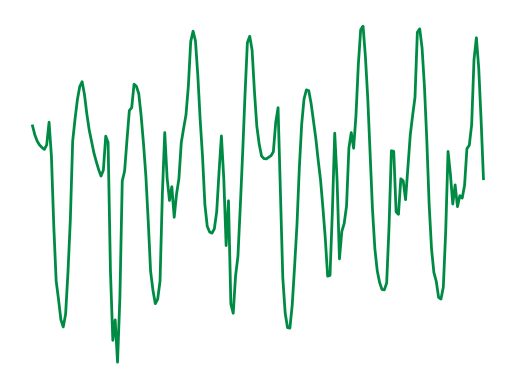

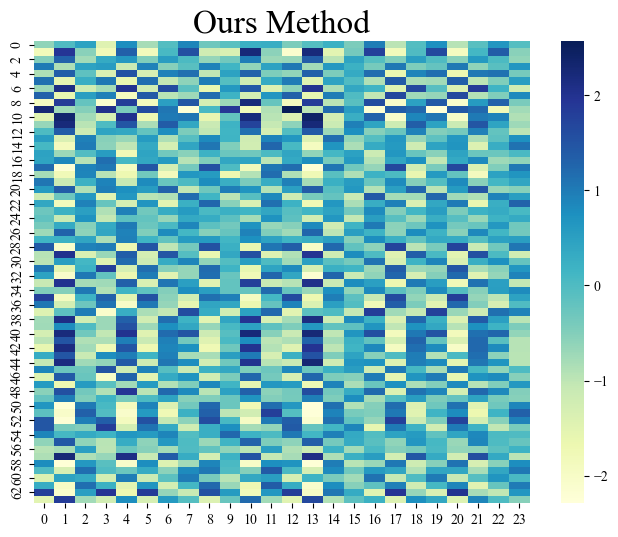

In [1]:
from neuralforecast.core import NeuralForecast
nf = NeuralForecast.load('checkpoints/best_ETTh1/')
nf.models[0].hparams
h1 = nf.predict()

<Axes: xlabel='unique_id'>

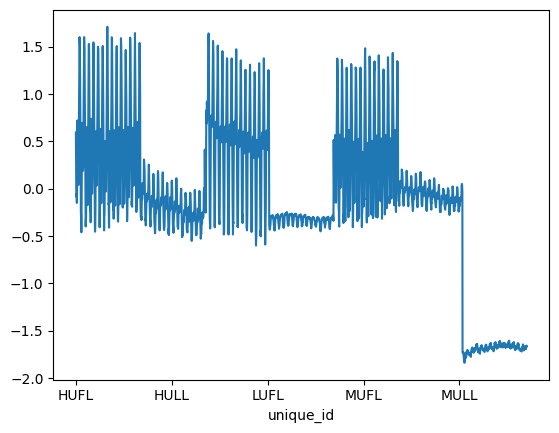

In [5]:
h1['MIXModel'].plot()

Global seed set to 2023


16-mixed


Predicting: 0it [00:00, ?it/s]

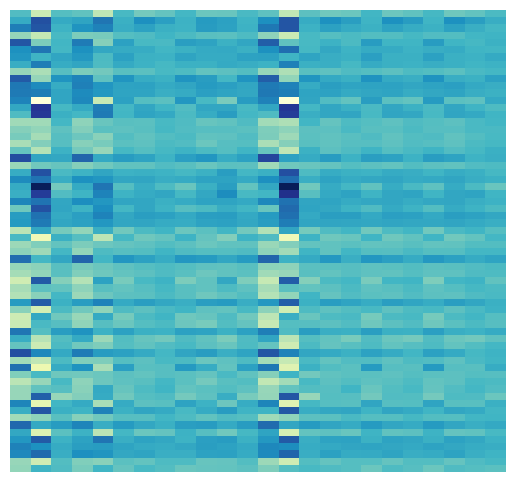

In [2]:
from neuralforecast.core import NeuralForecast
nf = NeuralForecast.load('checkpoints/test_tst_ETTh1')
# nf.models[0].hparams
h = nf.predict()

<Axes: xlabel='unique_id'>

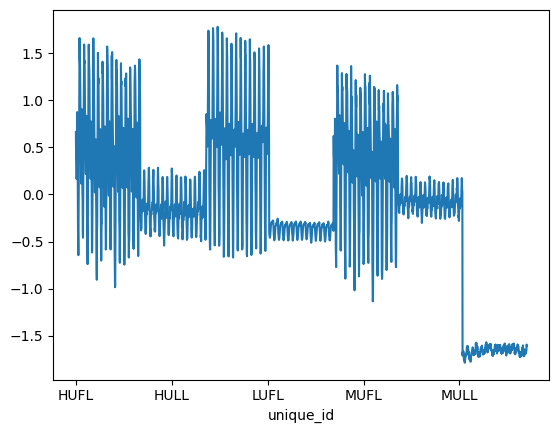

In [3]:
h['PatchTST'].plot()

In [63]:
### 这个文件和automixmodel是一样的，只是为了测试交叉验证的结果和
# predictisample的结果是否一致，有可能是predictisample的结果没有经过标准化。

# 经过实验证明predictinsample的结果确实没有标准化

import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import pandas as pd

from neuralforecast.core import NeuralForecast
from neuralforecast.models.mixmodel_rescale_deco import MIXModel
from neuralforecast.models import PatchTST, NHITS

from neuralforecast.losses.pytorch import MAE, MSE
from neuralforecast.losses.numpy import mae, mse

# from datasetsforecast.long_horizon import LongHorizon, LongHorizonInfo
from datasetsforecast.long_horizon2 import LongHorizon2, LongHorizon2Info

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)


input_size = 512
horizon = 720
dataset = "ETTh1"
epochs = 300

Y_df = LongHorizon2.load(directory="./data/", group=dataset)
Y_df["ds"] = pd.to_datetime(Y_df["ds"])
n_time = LongHorizon2Info[dataset].n_time
freq = LongHorizon2Info[dataset].freq
val_size = LongHorizon2Info[dataset].val_size
test_size = LongHorizon2Info[dataset].test_size
# test_size = 3000
Y_df.drop(columns=["index"], inplace=True)

mixmodel = MIXModel(
        h = horizon,
        input_size = input_size,
        transformer_input_size = 192,
        n_blocks = [3, 3, 3],
        mlp_units = 3 * [[64, 64]],
        n_pool_kernel_size = [16, 8, 1],
        n_freq_downsample = [16, 8, 1],
        pooling_mode = "MaxPool1d",
        interpolation_mode = "linear",
        dropout_prob_theta=0.2,
        mlp_activation = "ReLU",
        # decoder_layers = 1,
        encoder_layers = 3,
        n_heads = 4,
        hidden_size = 64,
        linear_hidden_size = 256,
        dropout = 0.2,
        fc_dropout = 0.2,
        head_dropout = 0.0,
        attn_dropout = 0.0,
        patch_len = 16,
        stride = 8,
        revin = True,
        revin_affine = False,
        revin_subtract_last = True,
        activation = "gelu",
        res_attention = True,
        batch_normalization = True,
        learn_pos_embed = True,
        loss=MAE(),
        valid_loss=MAE(),
        max_steps = epochs,
        learning_rate = 1e-3,
        num_lr_decays = 3,
        early_stop_patience_steps = 2,
        val_check_steps = 10,
        batch_size = 32,
        valid_batch_size = None,
        windows_batch_size = 1024, 
        inference_windows_batch_size = 1024,
        step_size = 1,
        scaler_type = "identity",
        random_seed = 2023,
        num_workers_loader = 0, # 取决于 cpu 数量
        stat_exog_list=None,
        hist_exog_list=None,
        futr_exog_list=None,
        exclude_insample_y=False,
        drop_last_loader = False,
)

patchtst = PatchTST(
        h = horizon,
        input_size = 192,
        loss=MAE(),
        batch_size = 32,
        learning_rate = 1e-3,
        max_steps = epochs,
        early_stop_patience_steps = 2,
        val_check_steps = 10,
)

nhits = NHITS(
        h = horizon,
        input_size = input_size,
        loss=MAE(),
        batch_size = 32,
        learning_rate = 1e-3,
        max_steps = epochs,
        early_stop_patience_steps = 2,
        val_check_steps = 10,
)

# print(test_size-192,192*50)
nf = NeuralForecast(models=[mixmodel,nhits,patchtst], freq=freq)
Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size,step_size=720, n_windows=None)
# # nf.fit(df=Y_df, val_size=val_size)
# from neuralforecast.losses.numpy import mae, mse

# y_true = Y_hat_df.y.values
# y_hat = Y_hat_df["MIXModel"].values
# n_series = len(Y_hat_df.unique_id.unique())
# y_true = y_true.reshape(n_series, -1, horizon)
# y_hat = y_hat.reshape(n_series, -1, horizon)
# print("\n" * 4)
# print("Parsed results")
# print(f"MIXModel {dataset} h={horizon}")
# # print("test_size", test_size)
# print("y_true.shape (n_series, n_windows, n_time_out):\t", y_true.shape)
# print("y_hat.shape  (n_series, n_windows, n_time_out):\t", y_hat.shape)
# # print(' best validation hyperparameter:\t', nf.models[0].results.get_best_result().config)
# print("MSE: ", mse(y_hat, y_true))
# print("MAE: ", mae(y_hat, y_true))

Global seed set to 2023
Global seed set to 1
Global seed set to 1


2018-02-20 23:00:00 2880 <Hour>
16-mixed


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

16-mixed


Predicting: 0it [00:00, ?it/s]

32-true


Sanity Checking: 0it [00:00, ?it/s]

nhits的参数量： 12972228


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

32-true


Predicting: 0it [00:00, ?it/s]

32-true


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

32-true


Predicting: 0it [00:00, ?it/s]

In [26]:
# nf.save('checkpoints/best_ECL',overwrite=False)


Global seed set to 2023


2018-02-20 23:00:00 14400 <Hour>
16-mixed


Predicting: 0it [00:00, ?it/s]

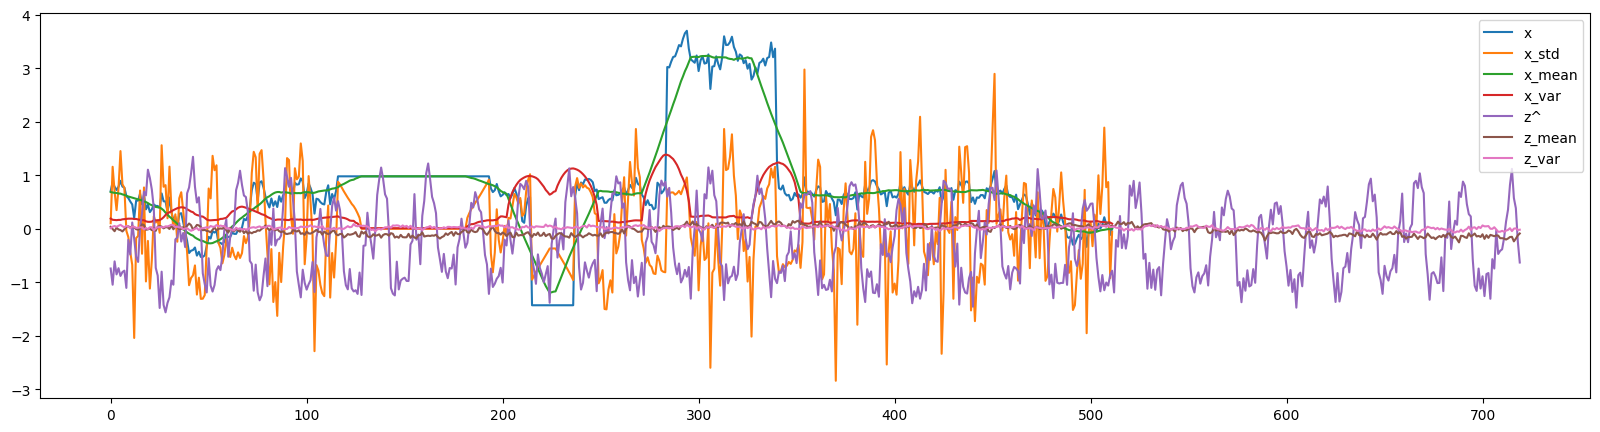

In [4]:
from neuralforecast.core import NeuralForecast
nf = NeuralForecast.load('checkpoints/mix_std_deco_ETTh1_720')
Y_hat_df = nf.predict_insample(step_size=720)
# nf.models[0].hparams

<Axes: >

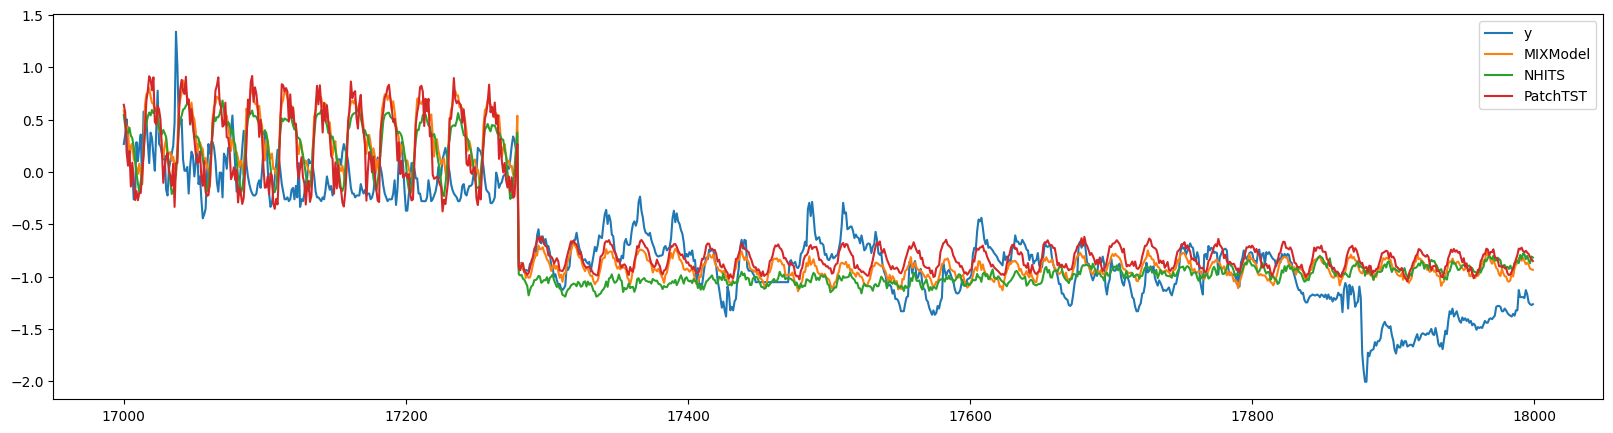

In [61]:
Y_hat_df[['y','MIXModel','NHITS','PatchTST']][17000:18000].plot(figsize=(20,5))

<Axes: >

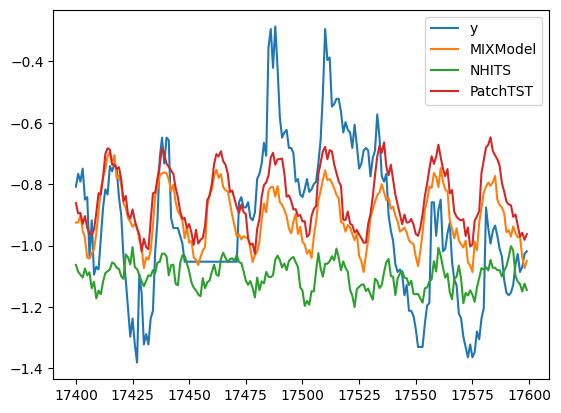

In [64]:
Y_hat_df[['y','MIXModel','NHITS','PatchTST']][17400:17600].plot()

<Axes: >

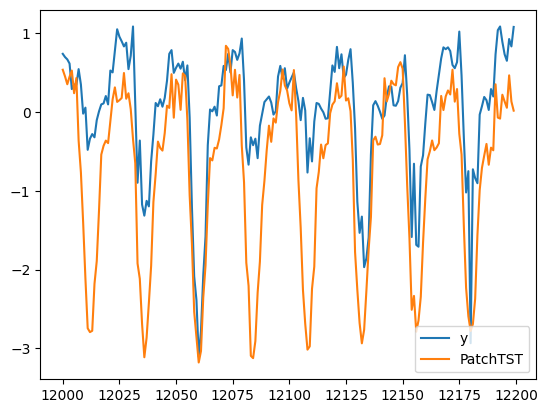

In [65]:
Y_hat_df[['y','PatchTST']][12000:12200].plot()

<Axes: >

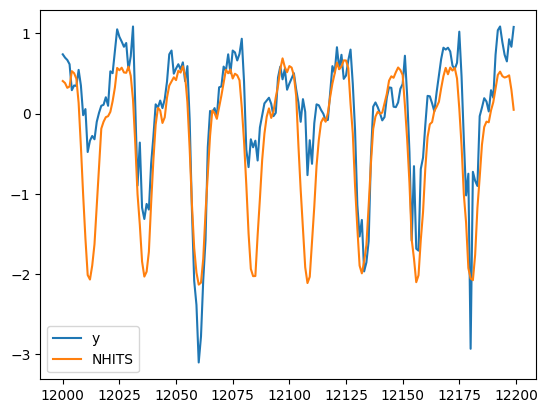

In [66]:
Y_hat_df[['y','NHITS']][12000:12200].plot()

<Axes: >

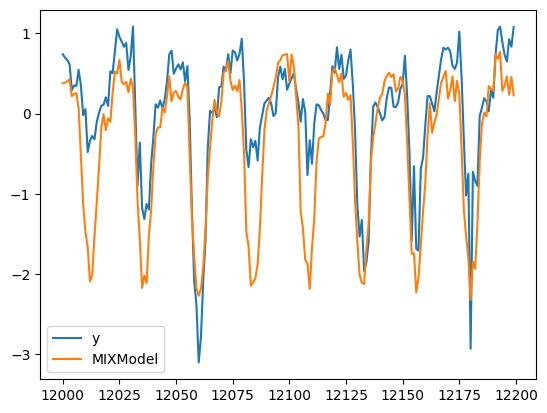

In [67]:
Y_hat_df[['y','MIXModel']][12000:12200].plot()

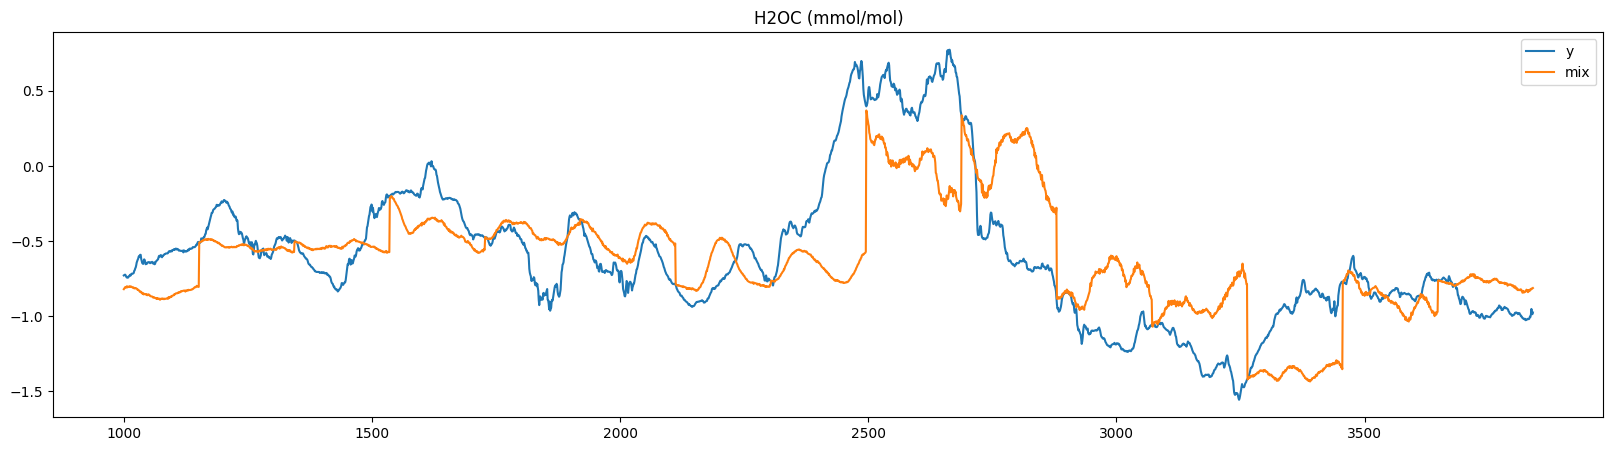

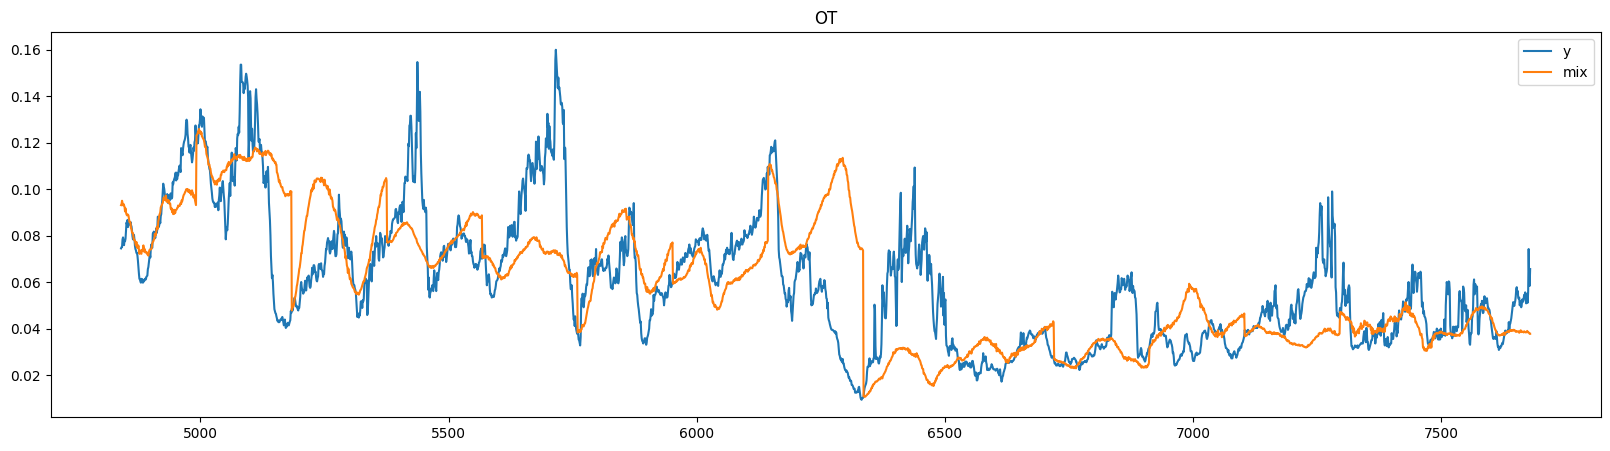

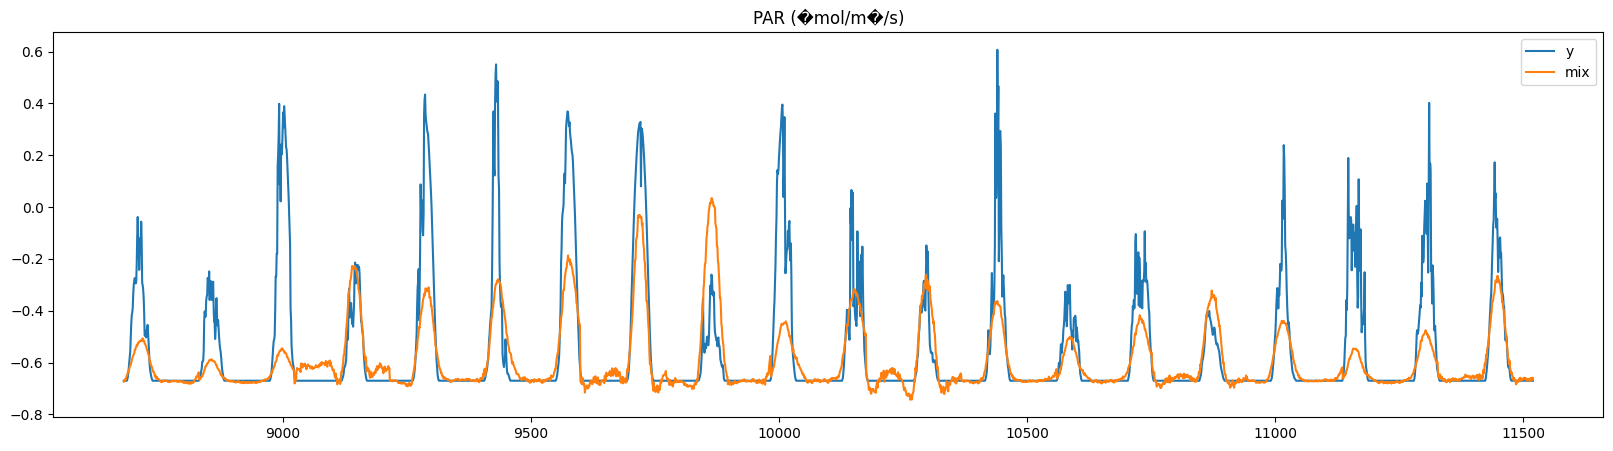

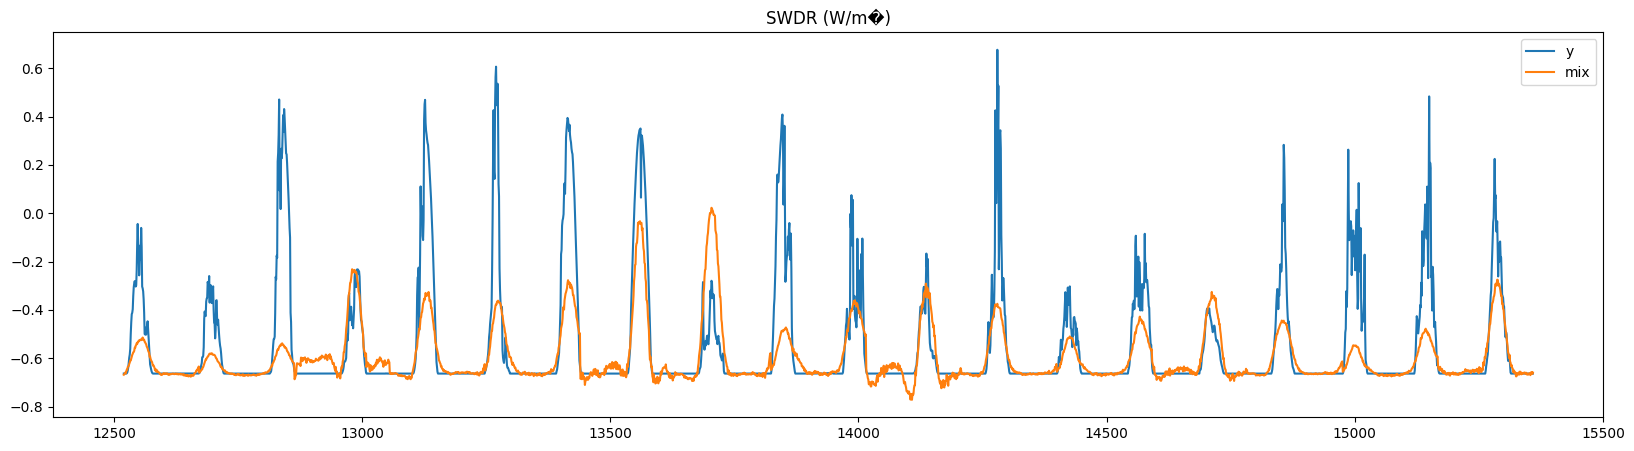

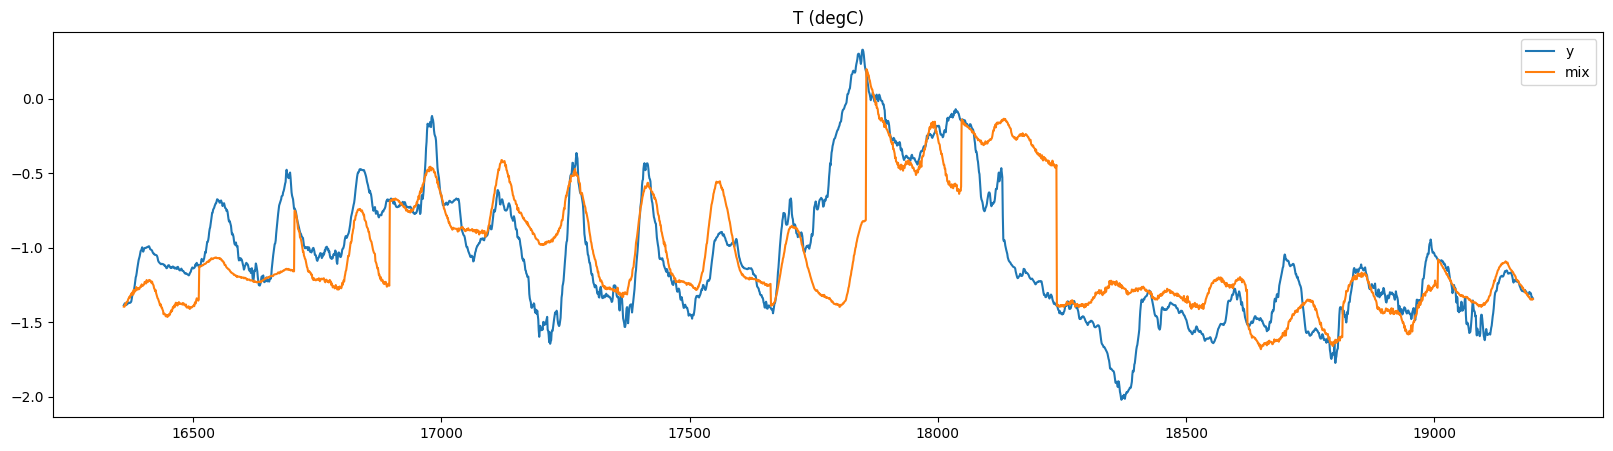

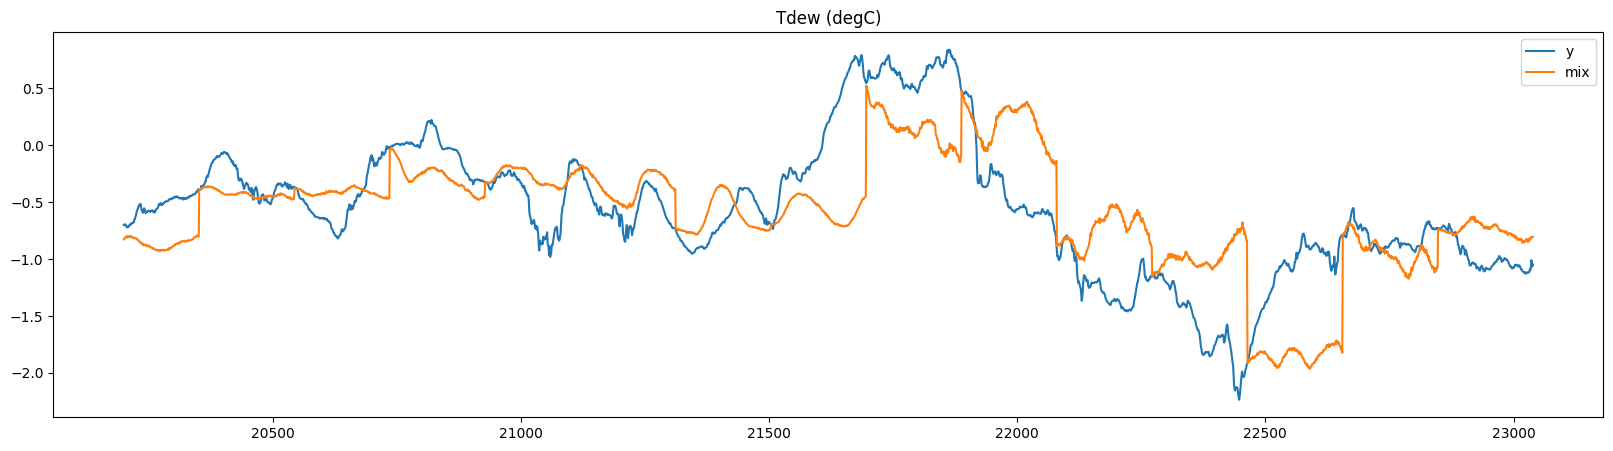

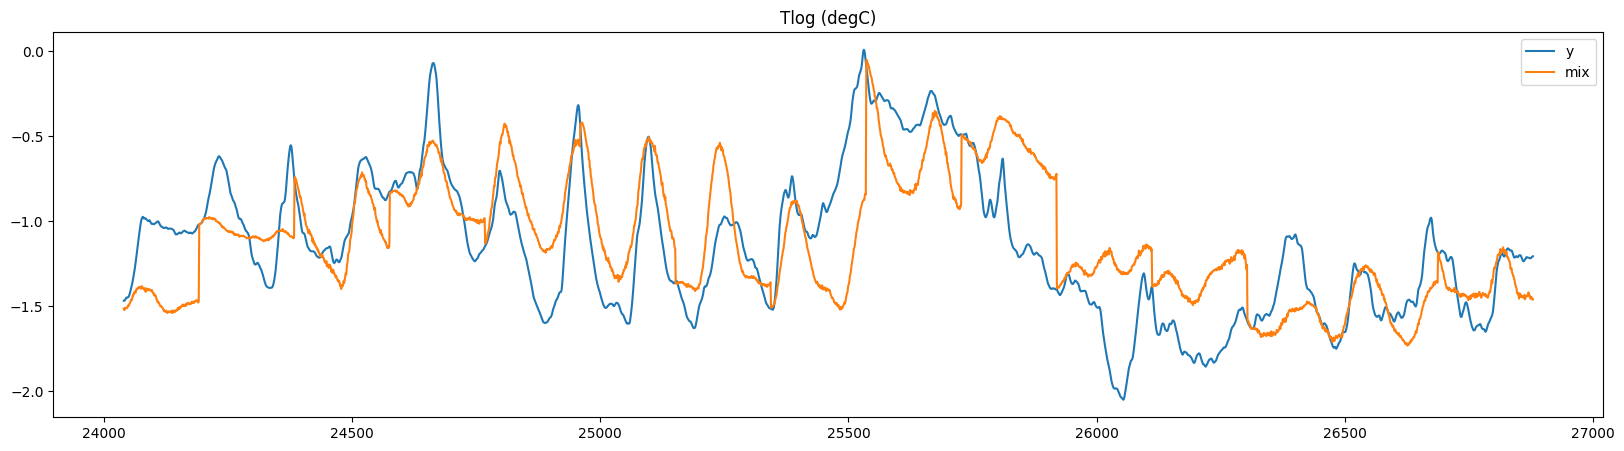

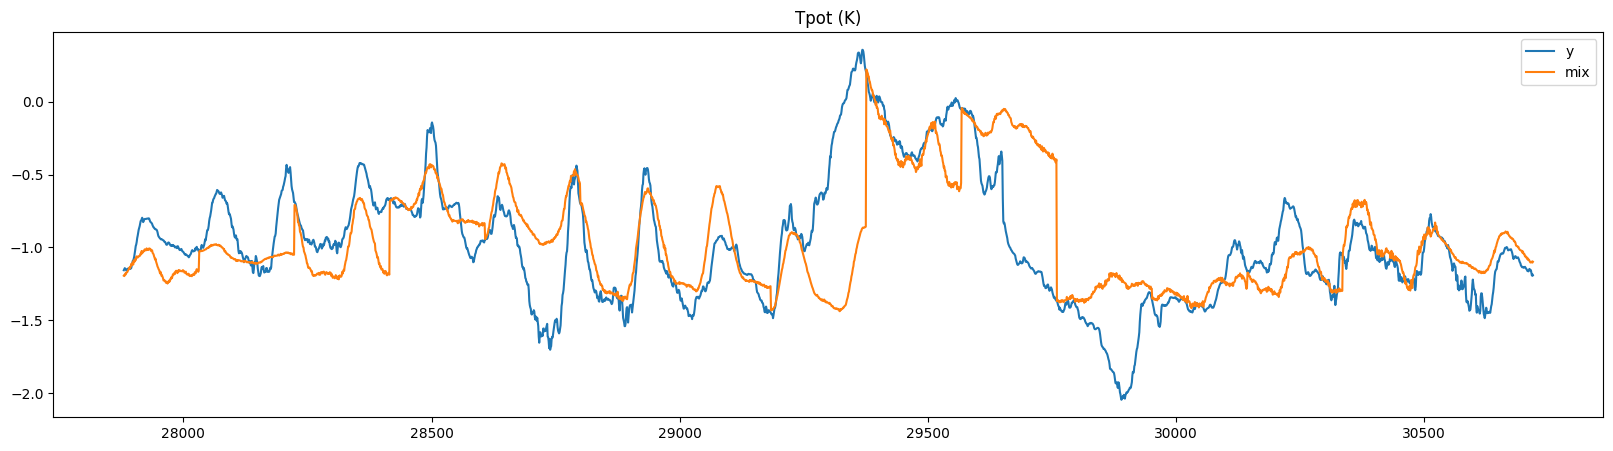

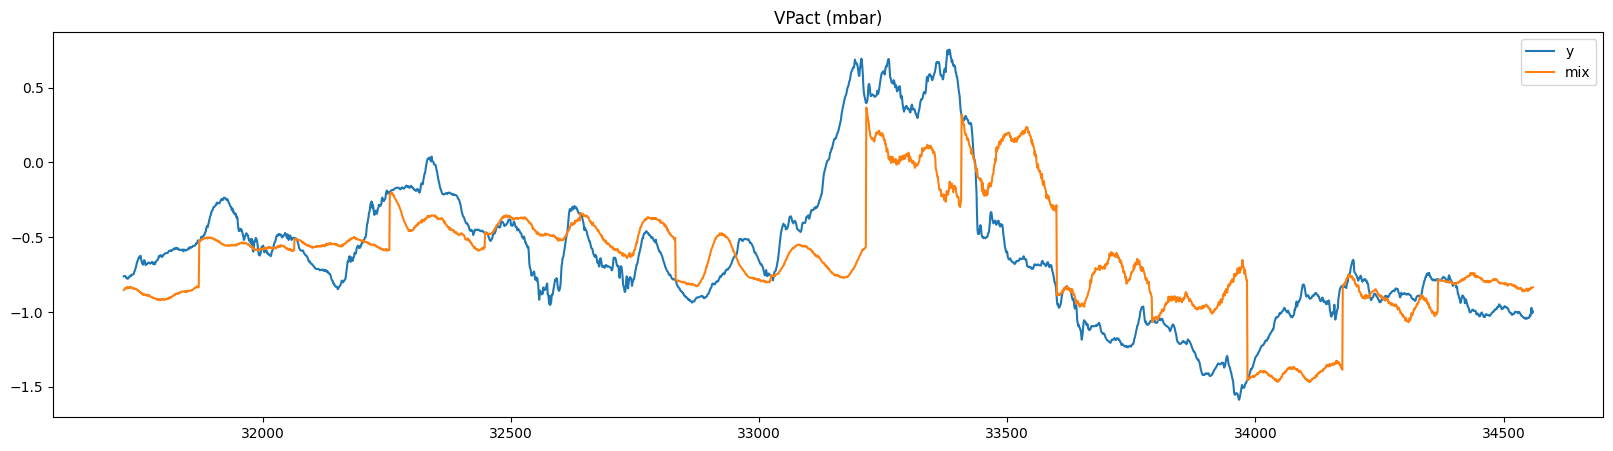

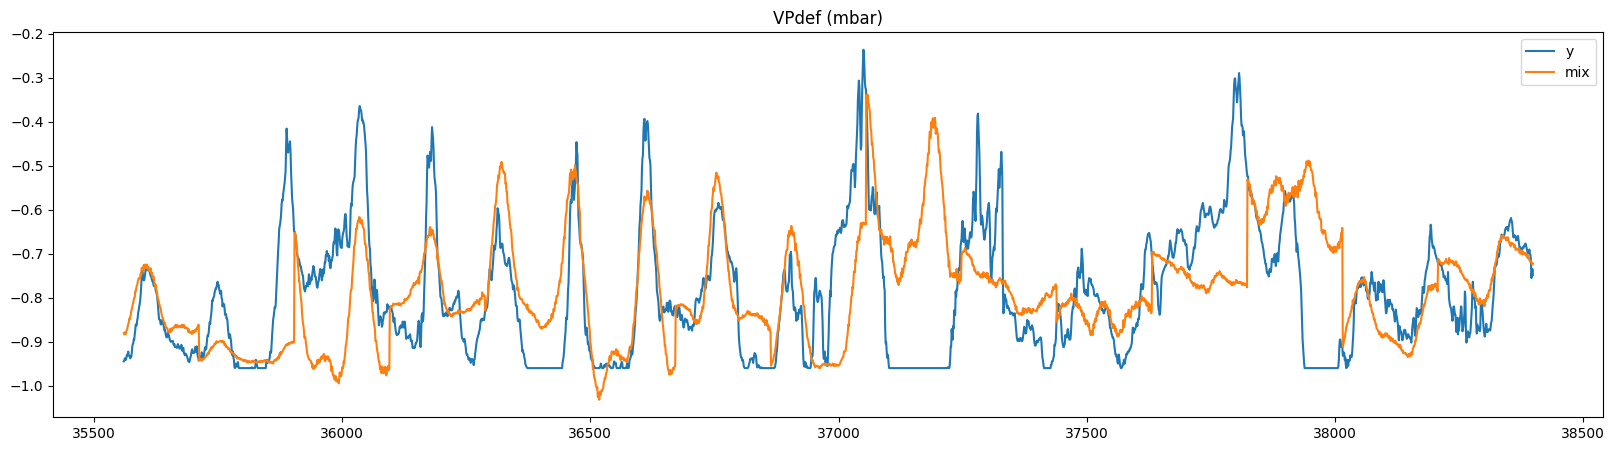

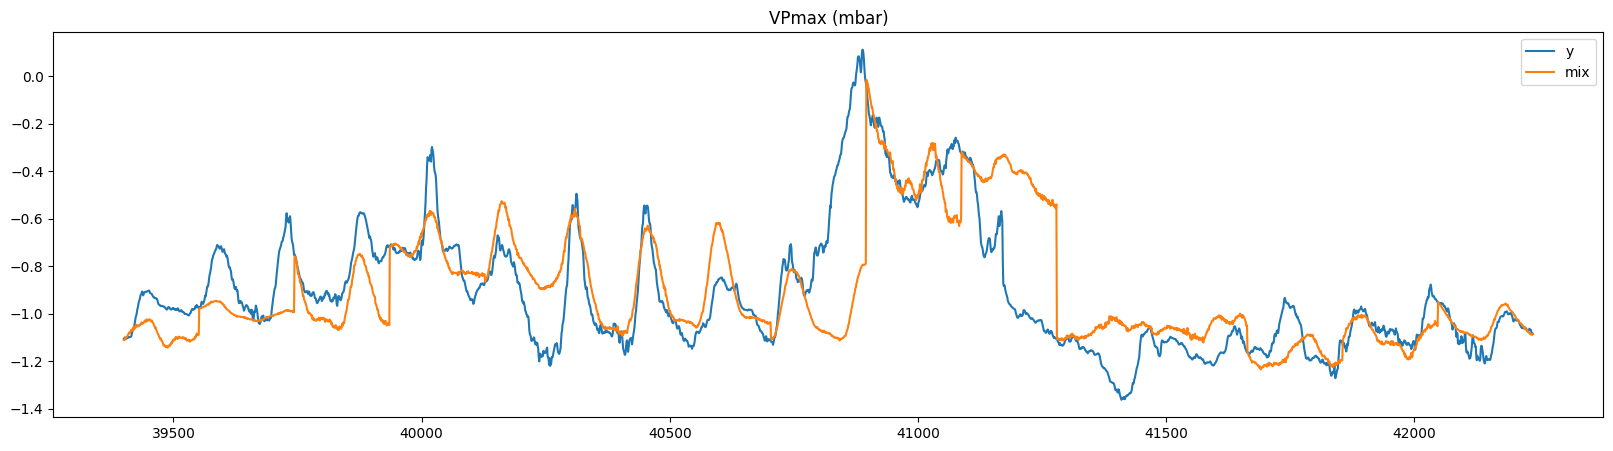

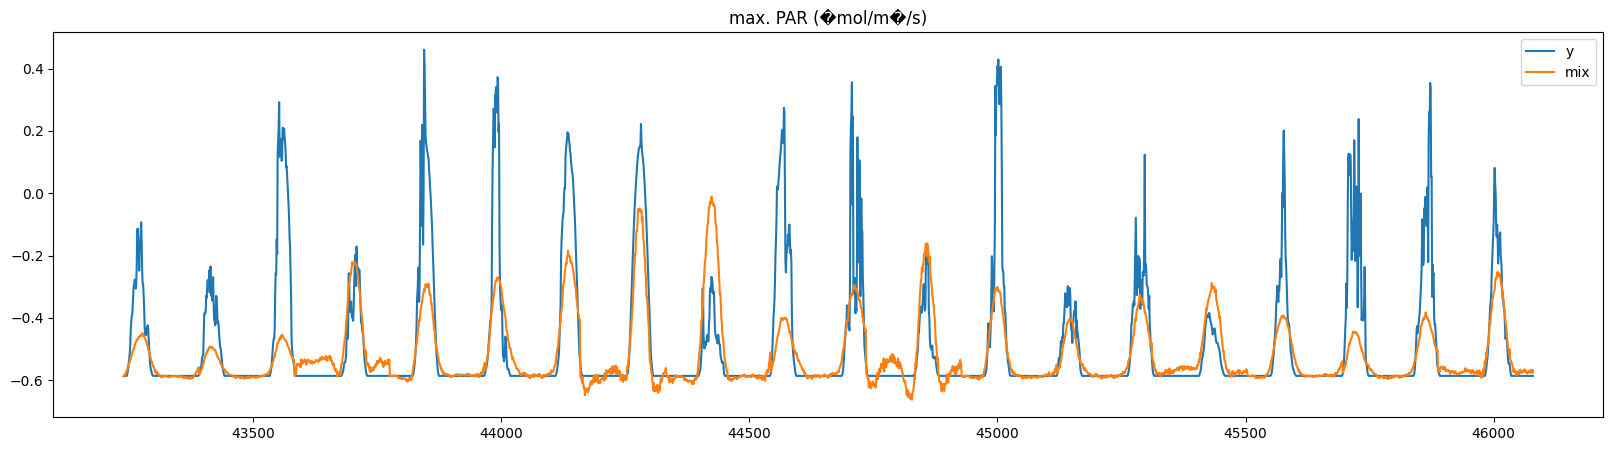

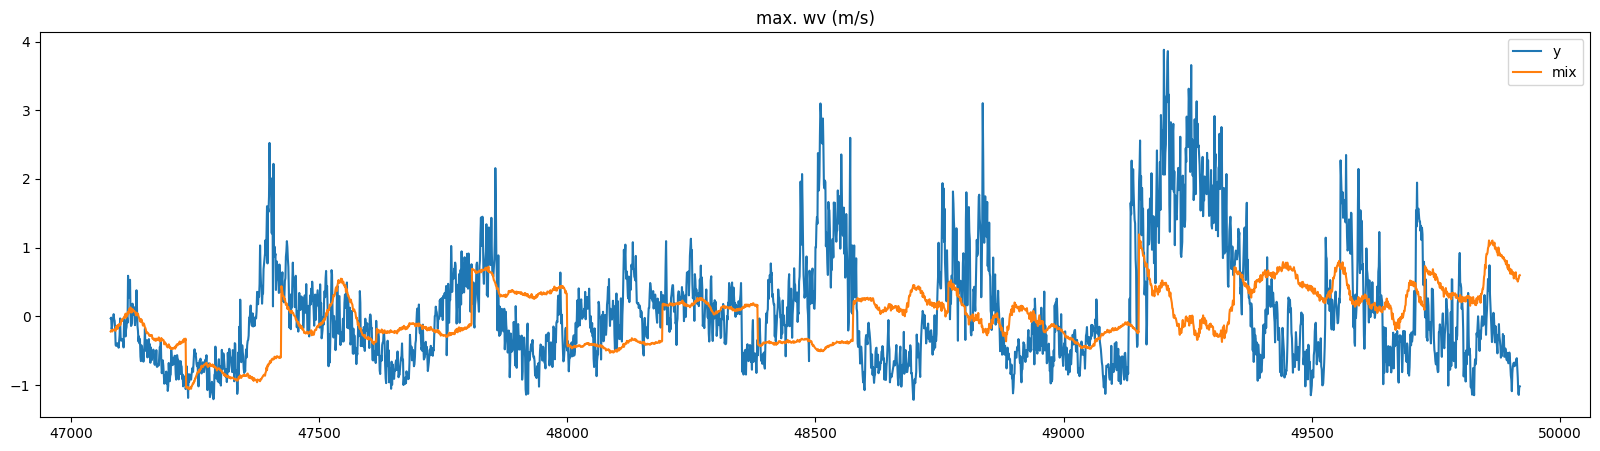

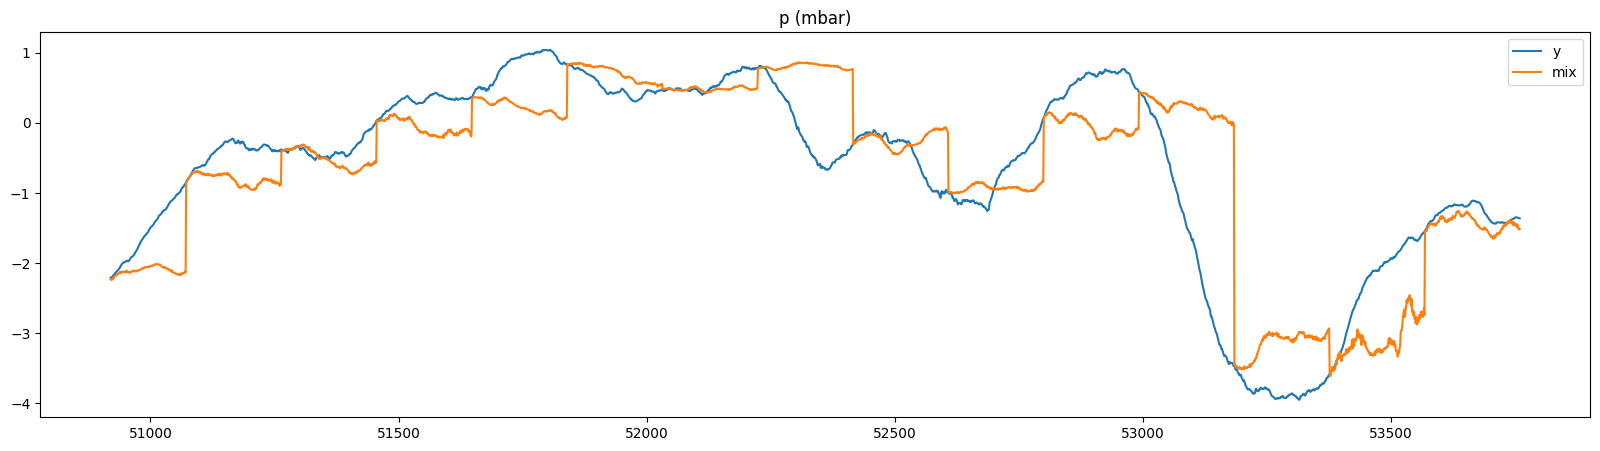

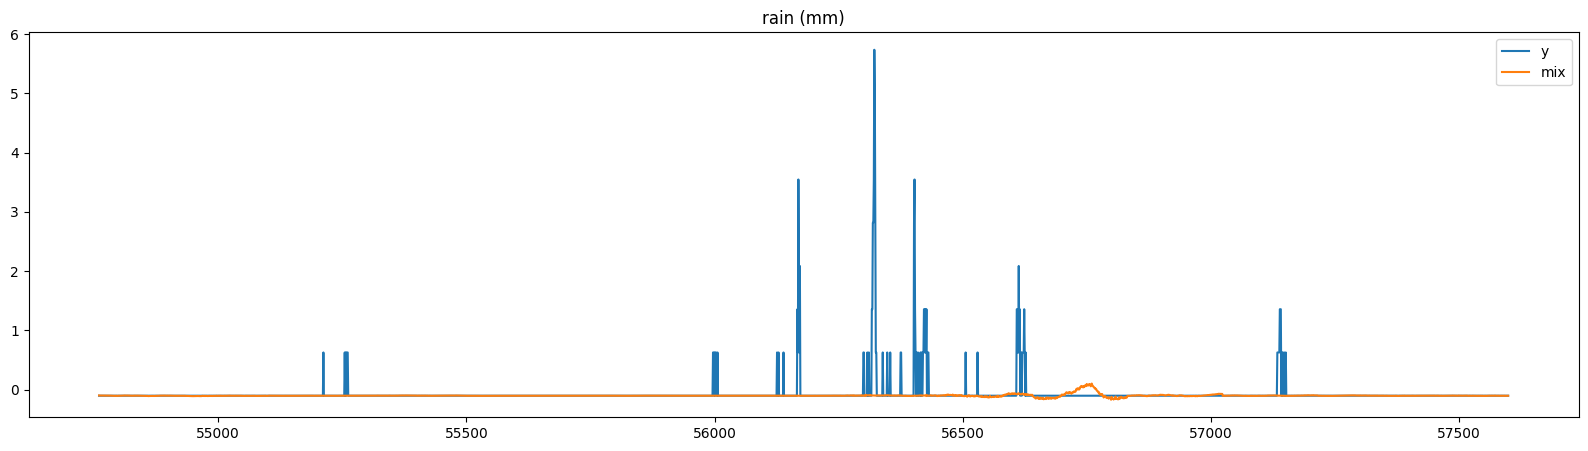

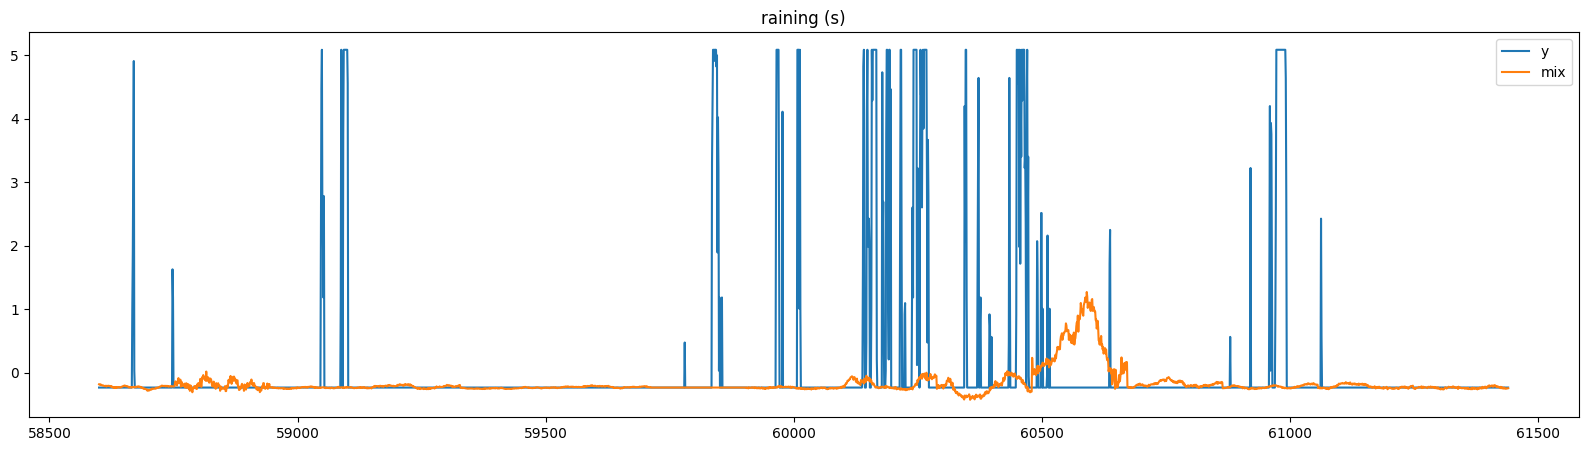

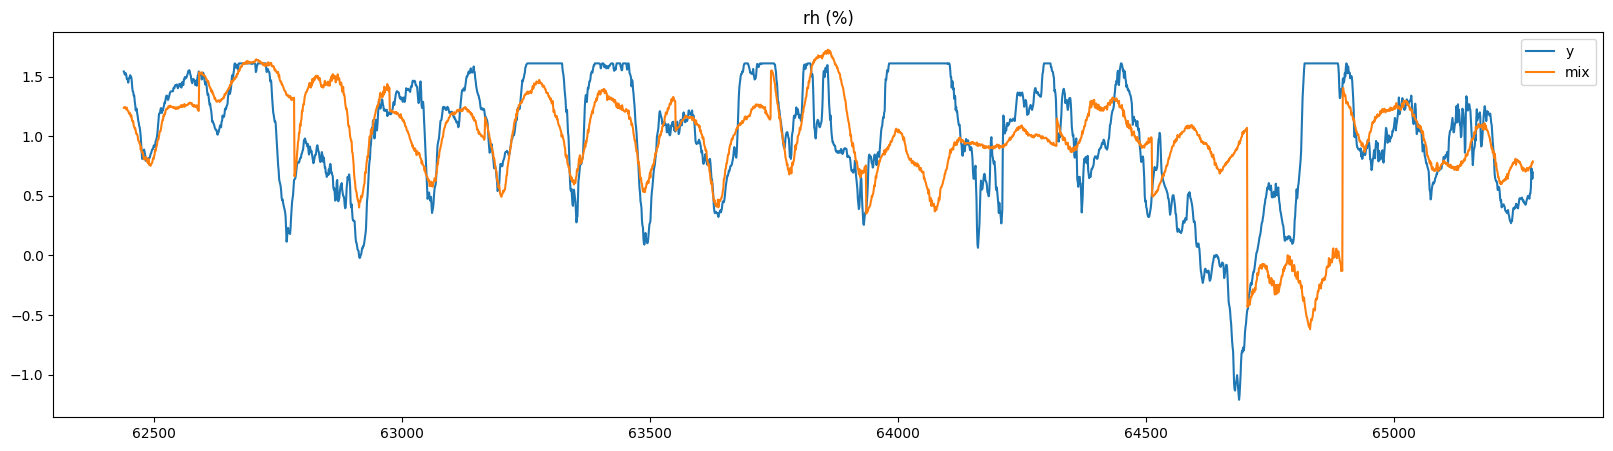

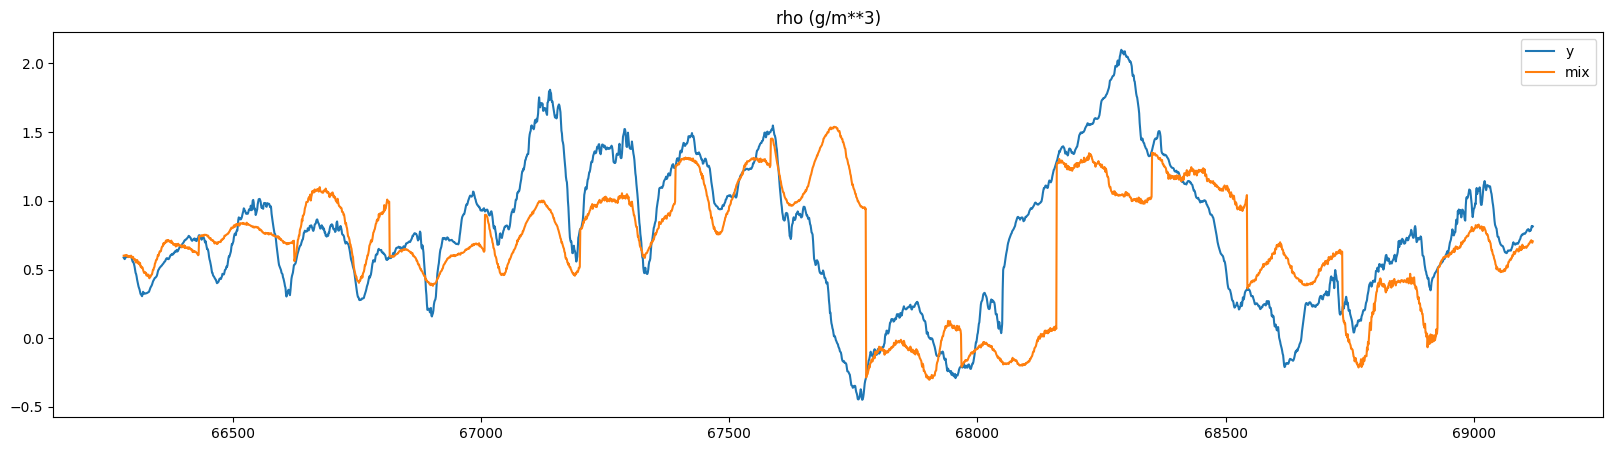

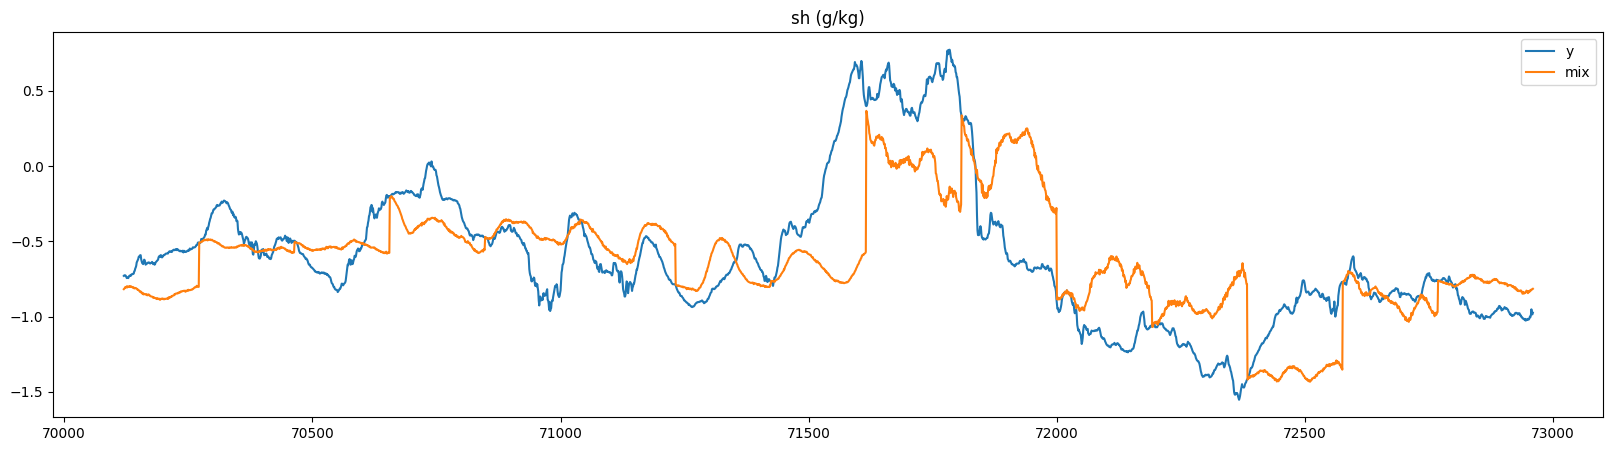

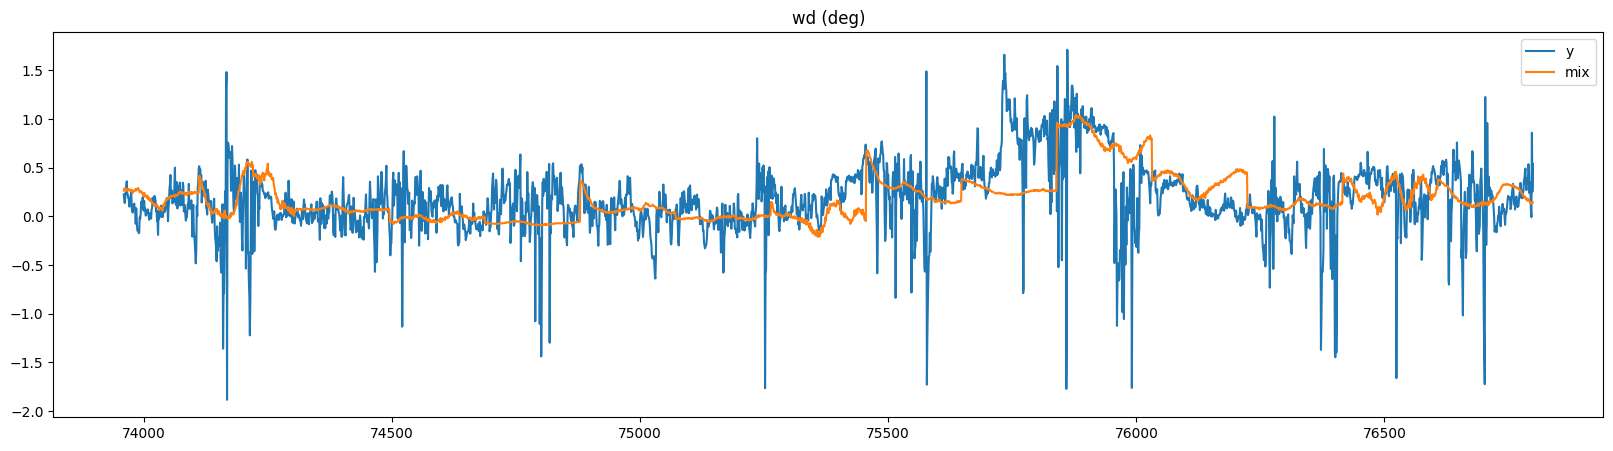

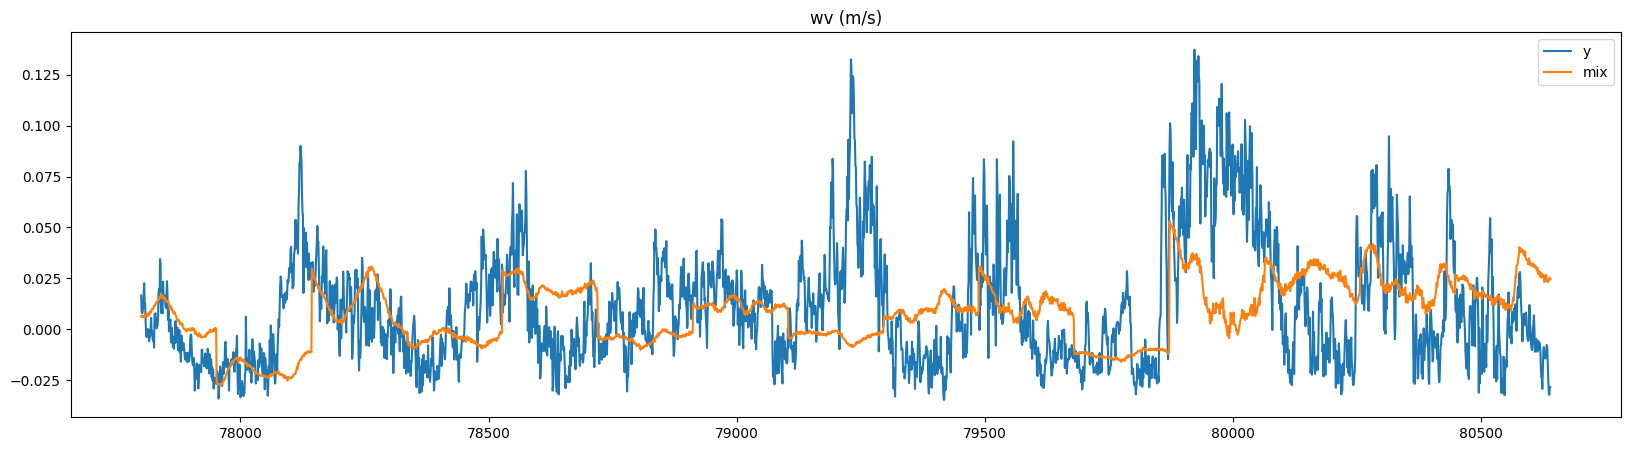

In [19]:
import matplotlib.pyplot as plt
for column in Y_hat_df['unique_id'].unique():

    start_p = 1000
    end_p = 10000
    plt.figure(figsize=(20,5))
    plt.title(column)
    plt.plot(Y_hat_df[Y_hat_df['unique_id']==column][start_p:end_p]['y'],label='y')
    plt.plot(Y_hat_df[Y_hat_df['unique_id']==column][start_p:end_p]['MIXModel'],label='mix')
    plt.legend()

In [10]:


from neuralforecast.losses.numpy import mae, mse
horizon = 336
dataset = 'ETTh2'
y_true = Y_hat_df.y.values
y_hat = Y_hat_df["MIXModel"].values
n_series = len(Y_hat_df.unique_id.unique())
y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)
print("\n" * 4)
print("Parsed results")
print(f"MIXModel {dataset} h={horizon}")
# print("test_size", test_size)
print("y_true.shape (n_series, n_windows, n_time_out):\t", y_true.shape)
print("y_hat.shape  (n_series, n_windows, n_time_out):\t", y_hat.shape)
# print(' best validation hyperparameter:\t', nf.models[0].results.get_best_result().config)
print("MSE: ", mse(y_hat, y_true))
print("MAE: ", mae(y_hat, y_true))






Parsed results
MIXModel ETTh2 h=336
y_true.shape (n_series, n_windows, n_time_out):	 (7, 9, 336)
y_hat.shape  (n_series, n_windows, n_time_out):	 (7, 9, 336)
MSE:  0.3567675171933354
MAE:  0.40651655192410635
